## High Level Computer Vision 
### Exercise 2: Deep Neural Networks and Backpropagation

In [ ]:
Name = ""
Matriculation_Number = ""

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from resources.data_utils import get_CIFAR10_data
from resources.vis_utils import visualize_grid
#from resources.solutions import *
from resources.gradient_check import eval_numerical_gradient


Deep neural networks have shown staggering performances in various learning tasks, including computer vision, natural language processing, and sound processing. They have made the model design more flexible by enabling end-to-end training.

In this exercise, we get to have a first hands-on experience with neural network training. Many frameworks (e.g., PyTorch, Tensorflow, Caffe) allow easy usage of deep neural networks without precise knowledge of the inner workings of backpropagation and gradient descent algorithms. While these are very useful tools, it is important to get a good understanding of how to implement basic network training from scratch before using these libraries to speed up the process. For this purpose, we will implement a simple two-layer neural network and its training algorithm based on back-propagation using only basic matrix operations in questions 1 to 3. In question 4, we will use a popular deep learning library, PyTorch, to do the same and understand the advantages offered by using such tools.

As a benchmark to test our models, we consider an image classification task using the widely used CIFAR-10 dataset. This dataset consists of 50000 training images of 32x32 resolution with 10 object classes, namely airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The task is to code and train a parametrized model for classifying those images. This involves

- Implementing the feedforward model (Question 1).
- Implementing the backpropagation algorithm (gradient computation) (Question 2).
- Training the model using stochastic gradient descent and improving the model training with better hyper-parameters (Question 3).
- Using the PyTorch Library to implement the above and experiment with deeper networks (Question 4).

A note on notation: Throughout the exercise, notation $v_i$ is used to denote the $i$-th element of vector $v$.

### Question 1: Implementing the feedforward model (10 points)

In this question, we will implement a two-layered neural network architecture and the loss function to train it.

<img src="./resources/fig1.png" width="900" align=left>

**Model architecture.** Our architecture is shown in Fig.1. It has an input layer and two model layers – a hidden and an output layer. We start with randomly generated toy inputs of four dimensions and the number of classes K = 3 to build our model in Q1 and Q2, and in Q3 use images from the CIFAR-10 dataset to test our model on a real-world task. Hence input layer is 4-dimensional for now.

In the hidden layer, there are ten units. The input layer and the hidden
layer are connected via linear weighting matrix $W^{(1)}\in\mathbb{R}^{10\times
4}$ and the bias term $b^{(1)}\in\mathbb{R}^{10}$. The parameters $W^{(1)}$
and $b^{(1)}$ are to be learnt later on. A linear operation is performed,
$W^{(1)}x+b^{(1)}$, resulting in a 10 dimensional vector $z^{(2)}$. It is then
followed by a relu non-linear activation $\phi$, applied element-wise on each
unit, resulting in the activations $a^{(2)} = \phi(z^{(2)})$. Relu function has
the following form:
\begin{equation}
\label{eq:sigmoid}
\phi(u) =  \begin{cases}
      u, & \text{if}\ u\geq0 \\
      0, & \text{if}\ u <0
    \end{cases}
\end{equation}

A similar linear operation is performed on $a^{(2)}$, resulting in $z^{(3)}=W^{(2)}a^{(2)}+b^{(2)}$, where $W^{(2)}\in\mathbb{R}^{3\times 10}$ and $b^{(2)}\in\mathbb{R}^{3}$; it is followed by the softmax activation to result in $a^{(3)}=\psi(z^{(3)})$. The softmax function is defined by:
\begin{equation}
\psi(u)_i =  \frac{\exp^{u_i}}{\sum_j{\exp^{u_j}}} 
\end{equation}

The final functional form of our model is thus defined by
\begin{align}
\label{eq:feedforward-model-start}
a^{(1)} & = x \\\
z^{(2)} & = W^{(1)}a^{(1)}+b^{(1)} \\
a^{(2)} & = \phi(z^{(2)}) \\
z^{(3)} & = W^{(2)}a^{(2)}+b^{(2)} \\
\label{eq:feedforward-model-end}
f_\theta(x) := a^{(3)} & = \psi(z^{(3)}),
\end{align}
which takes a flattened 4 dimensional vector as input and outputs a $3$ dimensional vector, each entry in the output $f_k(x)$ representing the probability of image $x$ corresponding to the class $k$. We summarily indicate all the network parameters by $\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$.

**Implementation.** We are now ready to implement the feedforward neural network.

a) Implement the feedforward model. Verify that the scores you generate for the toy inputs match the correct scores. (5 points)

In [3]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def forward(self, X):
        """
        Compute the final outputs for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        A matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = 0.
        #############################################################################
        # TODO: Perform the forward pass, computing the class probabilities for the #
        # input. Store the result in the scores variable, which should be an array  #
        # of shape (N, C).                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # fcl
        z2 = X @ W1 + b1
        # relu
        a2 = np.multiply(z2, (z2 > 0))
        # fcl
        z3 = a2 @ W2 + b2
        # softmax
        scores = np.exp(z3) / np.sum(np.exp(z3), axis=1)[:, None]
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If the targets are not given then jump out, we're done
        return scores       

In [4]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

scores = net.forward(X)
print('Your scores:')
print(scores)
print()
print('Correct scores:')
correct_scores = np.asarray([
 [0.36446210, 0.22911264, 0.40642526],
 [0.47590629, 0.17217039, 0.35192332],
 [0.43035767, 0.26164229, 0.30800004],
 [0.41583127, 0.29832280, 0.28584593],
 [0.36328815, 0.32279939, 0.31391246]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

assert math.isclose(np.sum(np.abs(scores - correct_scores)), 0,  abs_tol=1e-6)

Your scores:
[[0.3644621  0.22911264 0.40642526]
 [0.47590629 0.17217039 0.35192332]
 [0.43035767 0.26164229 0.30800004]
 [0.41583127 0.2983228  0.28584593]
 [0.36328815 0.32279939 0.31391246]]

Correct scores:
[[0.3644621  0.22911264 0.40642526]
 [0.47590629 0.17217039 0.35192332]
 [0.43035767 0.26164229 0.30800004]
 [0.41583127 0.2983228  0.28584593]
 [0.36328815 0.32279939 0.31391246]]

Difference between your scores and correct scores:
2.9173411658645065e-08


b) We later guide the neural network parameters
$\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$ to fit the given data and label
pairs. We do so by minimising the loss function. A popular choice of the loss
function for training neural networks for multi-class classification is the
cross-entropy loss. For a single input sample $x_i$, with label $y_i$, the loss
function is defined as:
\begin{align}
J(\theta, x_i, y_i) &= -\log{P(Y=y_i,X=x_i)} \\
                    &= -\log{f_\theta(x_i)_{y_i}} \\
                    &= -\log{\psi(z^{(3)})_{y_i}} \\
J(\theta, x_i, y_i) &= -\log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum^K_j{\exp^{z^{(3)}_j}}}\right]
\label{eq:log-loss-softmax}
\end{align}

Averaging over the whole training set, we get 
\begin{equation}
\label{eq:log-loss-softmax-empirical}
J(\theta,\{x_i,y_i\}_{i=1}^{N}) = \frac{1}{N} \sum_{i=1}^N 
-log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum_j{\exp^{z^{(3)}_j}}}\right],
\end{equation}
where $K$ is the number of classes. Note that if the model has perfectly fitted
to the data (\emph{i.e.} $f_\theta^k(x_i)=1$ whenever $x_i$ belongs to class $k$ and 0
otherwise), then $J$ attains the minimum of $0$. 


Apart from trying to correctly predict the label, we have to prevent
overfitting the model to the current training data.  This is done by encoding
our prior belief that the correct model should be simple (Occam's razor); we
add an $L_2$ regularisation term over the model parameters $\theta$.
Specifically, the loss function is defined by:
\begin{equation}
\label{eq:log-loss-empirical-regularised}
\tilde{J}(\theta) = \frac{1}{N} \sum_{i=1}^N
-log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum_j{\exp^{z^{(3)}_j}}}\right]
+\lambda \left(||W^{(1)}||_2^2 + ||W^{(2)}||_2^2 \right),
\end{equation}
where $||\cdot||_2^2$ is the squared $L_2$ norm. For example,
\begin{equation}
\label{eq:L2-term}
||W^{(1)}||_2^2 = 
\sum_{p=1}^{10} \sum_{q=1}^{4} W_{pq}^{(1)2}
\end{equation}
By changing the value of $\lambda$ it is possible to give weights to your prior belief on the degree of simplicity (regularity) of the true model. 

Implement the final loss function and let it return the loss value. Verify the code by
running and matching the output cost $1.30378789133$. (5 points)

In [5]:
class TwoLayerNetv2(TwoLayerNet):
    def compute_loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = 0.
        #############################################################################
        # TODO: Perform the forward pass, computing the class probabilities for the #
        # input. Store the result in the scores variable, which should be an array  #
        # of shape (N, C).                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # fcl
        z2 = X @ W1 + b1
        # relu
        a2 = np.multiply(z2, (z2 > 0))
        # fcl
        z3 = a2 @ W2 + b2
        # softmax
        scores = np.exp(z3) / np.sum(np.exp(z3), axis=1)[:, None]
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = 0.
        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss.                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # calculate regularization penalty
        r1 = reg * np.sum(np.square(W1))
        r2 = reg * np.sum(np.square(W2))
        # compute softmax loss
        target_scores = scores[np.arange(y.size), y]
        logs = np.log(target_scores+1e-8)
        loss = (-np.sum(logs) / float(N)) + r1 + r2
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss

In [6]:
# Compute loss in the same function
def init_toy_model_v2():
    np.random.seed(0)
    return TwoLayerNetv2(input_size, hidden_size, num_classes, std=1e-1)

net_v2 = init_toy_model_v2()
loss = net_v2.compute_loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

assert math.isclose(np.sum(np.abs(loss - correct_loss)), 0,  abs_tol=1e-6)

Difference between your loss and correct loss:
3.679019733304756e-08


### Question 2: Backpropagation (15 points)

We train the model by solving
\begin{equation}
\label{eq:train-main}
\underset{\theta}{\min} \,\,  \tilde{J}(\theta)
\end{equation}
via stochastic gradient descent. Therefore, We need an efficient computation of the gradients $\nabla_\theta \tilde{J}(\theta)$. We use backpropagation of top layer error signals to the parameters $\theta$ at different layers.

In this question, you will be required to implement the backpropagation algorithm yourself from pseudocode. We will give a high-level description of what is happening in each line.

For those who are interested in the robust derivation of the algorithm, we include the optional exercise on the derivation of the backpropagation algorithm. A piece of prior knowledge of standard vector calculus, including the chain rule, would be helpful. 


**Backpropagation.** The backpropagation algorithm is simply a sequential application of the chain rule. It is applicable to any (sub-) differentiable model that is a composition of simple building blocks. In this exercise, we focus on the architecture with stacked layers of linear transformation + relu non-linear activation.

The intuition behind the backpropagation algorithm is as follows. Given a training example $(x, y)$, we first run the feedforward to compute all the activations throughout the network, including the output value of the model $f_\theta(x)$ and the loss $J$. Then, for each parameter in the model, we want to compute the effect that parameter has on the loss. This is done by computing the derivatives of the loss w.r.t for each model parameter.

The backpropagation algorithm is performed from the top of the network (loss layer) to the bottom. It sequentially computes the gradient of the loss function with respect to each layer's activations and parameters.

Let’s start by deriving the gradients of the un-regularized loss function w.r.t final layer activations $z^{(3)}$. We will then use this in the chain rule to compute analytical expressions for gradients of all the model parameters.

(a) Verify that the loss function (in Q1) has the gradient w.r.t $z^{(3)}$ as below.
\begin{equation}
\frac{\partial J}{\partial z^{(3)}}\left(\{x_i,y_i\}_{i=1}^{N}\right) = \frac{1}{N}\left(\psi(z^{(3)}) - \Delta\right), 
\end{equation}
where $\Delta$ is a matrix of $N\times K$ dimensions with 
\begin{equation}
        \Delta_{ij} = \begin{cases}
        1, & \text{if}\ y_i =j \\
                0, & \text{otherwise}
\end{cases}
\end{equation}
(please write your answer in the block below, 2 points)

Derivative of mse loss

b) To compute the effect of the weight matrix $W^{(2)}$ on the loss (in Q1) incurred by the network, we compute the
partial derivatives of the loss function with respect to $W^{2}$.  This is done
by applying the chain rule. Verify that the partial derivative of the loss
w.r.t $W^{(2)}$ is  
\begin{align}
\label{eq:grad-loss-multi}
\frac{\partial J}{\partial W^{(2)}}\left(\{x_i,y_i\}_{i=1}^{N}\right) &= \frac{\partial J}{\partial z^{(3)}} \cdot \frac{\partial z^{(3)}}{\partial W^{(2)}} \\
&= \frac{1}{N} (\psi(z^{(3)}) - \Delta) a^{(2)'}
\end{align}

Similary, verify that the regularized loss has the derivatives

\begin{equation}
\frac{\partial \tilde{J}}{\partial W^{(2)}} = \frac{1}{N} (\psi(z^{(3)}) - \Delta) a^{(2)'} + 2\lambda W^{(2)}
\end{equation}

(please write your answer in the block below, 2 points)

We apply chain rule and then easy derivatives

c) We can repeatedly apply chain rule as discussed above to obtain the derivatives of the loss with respect to all the parameters of the model $\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$.
Dervive the expressions for the derivatives of the regularized loss (in Q1) w.r.t $W^{(1)}$, $b^{(1)}$, $b^{(2)}$ now.
(please write your answer in the block below, 6 points)

d) Using the expressions you obtained for the derivatives of the loss w.r.t model
parameters, implement the back-propagation algorithm. Run the code and verify that the
gradients you obtained are correct using numerical gradients (already
implemented in the code). The maximum relative error between the gradients you
compute and the numerical gradients should be less than 1e-8 for all parameters.
(5 points)

In [7]:
class TwoLayerNetv3(TwoLayerNetv2):
    def back_propagation(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D= X.shape


        # Compute the forward pass
        scores = 0.
        #############################################################################
        # TODO: Perform the forward pass, computing the class probabilities for the #
        # input. Store the result in the scores variable, which should be an array  #
        # of shape (N, C).                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)****             
        # fcl
        z2 = X @ W1 + b1
        # relu
        a2 = np.multiply(z2, (z2 > 0))
        # fcl
        z3 = a2 @ W2 + b2
        # softmax
        scores = np.exp(z3) / np.sum(np.exp(z3), axis=1)[:, None]
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = 0.
        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss.                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        r1 = reg * np.sum(np.square(W1))
        r2 = reg * np.sum(np.square(W2))
        target_scores = scores[np.arange(y.size), y]
        logs = np.log(target_scores+1e-8)
        loss = (-np.sum(logs) / float(N)) + r1 + r2
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Backward pass: compute gradients
        grads = {}
        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] should store the gradient on W1, and be a matrix of same size #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        targets = np.zeros_like(scores)
        targets[np.arange(y.size), y] = 1
        grad_loss = (scores - targets) / N
        grads['W2'] = a2.T @ grad_loss + 2 * reg * W2
        grads['b2'] = np.sum(grad_loss, axis=0)
        grad_a2 = grad_loss @ W2.T
        grad_z2 = np.multiply((z2>0), grad_a2)
        grads['W1'] = X.T @ grad_z2 + 2 * reg * W1
        grads['b1'] = np.sum(grad_z2, axis=0)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss, grads

In [8]:
# Compute the gradient
def init_toy_model_v3():
    np.random.seed(0)
    return TwoLayerNetv3(input_size, hidden_size, num_classes, std=1e-1)

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

net_v3 = init_toy_model_v3()

loss, grads = net_v3.back_propagation(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net_v3.back_propagation(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net_v3.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 6.799706e-08
b2 max relative error: 3.065721e-08
W1 max relative error: 1.914147e-06
b1 max relative error: 1.313493e-07


### Question 3: Stochastic gradient descent training (10 points)

We have implemented the backpropagation algorithm for computing the parameter gradients and have verified that it indeed gives the correct gradient. We are now ready to train the network. We solve Eq.15 with the stochastic gradient descent.

Typically neural networks are large and are trained with millions of data
points. It is thus often infeasible to compute the gradient $\nabla_\theta
\tilde{J}(\theta)$ that requires the accumulation of the gradient over the
entire training set. Stochastic gradient descent addresses this problem by
simply accumulating the gradient over a small random subset of the training
samples (minibatch) at each iteration. Specifically, the algorithm is as
follows,

<img src="./resources/alg1.png" width="900" align=left>

where the gradient $\nabla_\theta \tilde{J}(\theta,\{(X^\prime_j,y^\prime_j)\}_{j=1}^B)$ is computed only on the current randomly sampled batch.

Intuitively, $v = -\nabla_\theta \tilde{J}(\theta^{(t-1)})$ gives the direction
to which the loss $\tilde{J}$ decreases the most (locally), and therefore we
follow that direction by updating the parameters towards that direction
$\theta^{(t)} = \theta^{(t-1)} + v$. 

a) Implement the stochastic gradient descent algorithm and run the training on the toy data. Your model
should be able to  obtain loss <= 0.02 on the training set and the training
curve should look similar to the one shown in figure 2.

<img src="./resources/fig2.png" width="500" align=left>

In [9]:
class TwoLayerNetv4(TwoLayerNetv3):
    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = X
            y_batch = y

            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            batch_idxs = np.random.choice(np.arange(y.size), size=batch_size, replace=True)
            X_batch = X[batch_idxs]
            y_batch = y[batch_idxs]
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # Compute loss and gradients using the current minibatch
            loss, grads = self.back_propagation(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            for key, value in grads.items(): 
                self.params[key] = self.params[key] - learning_rate * value
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }
    
    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        ###########################################################################
        # TODO: Implement this function; it should be VERY simple!                #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        scores = self.forward(X)
        y_pred = np.argmax(scores, axis=1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return y_pred

Final training loss:  0.01714959776498867


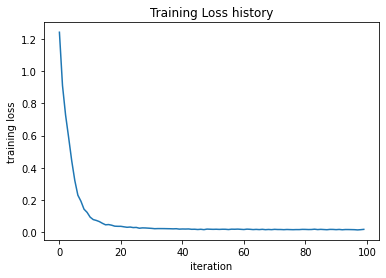

In [13]:
def init_toy_model_v4():
    np.random.seed(0)
    return TwoLayerNetv4(input_size, hidden_size, num_classes, std=1e-1)

net_v4 = init_toy_model_v4()
stats = net_v4.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)
print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

b) We are now ready to train our model on a real image dataset. For this, we will use
the CIFAR-10 dataset.  Since the images are of size $32\times 32$ pixels with 3
color channels, this gives us 3072 input layer units, represented by a vector
$x\in\mathbb{R}^{3072}$. The code to load the data and train the model is provided with
some default hyperparameters. With default
hyperparameters, if previous questions have been done correctly, you should get
a validation set accuracy of about 29\%. This is very poor.
Your task is to debug the model training and come up with better hyperparameters
to improve the performance on the validation set.
Visualize the training and validation performance curves to help with this analysis.
There are several pointers provided in the comments to 
help you understand why the network might be underperforming.
Once you have tuned your hyperparameters, and get validation accuracy greater
than 48\% run your best model on the test set once and report the performance.

**Download CIFAR-10 using this link: <http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz>**
<br />
**Decompress the downloaded dataset, and put the `cifar-10-batches-py` folder in the foleder `datasets`**

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


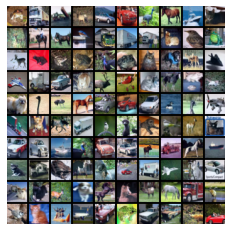

iteration 0 / 1000: loss 2.302974
iteration 100 / 1000: loss 2.302658
iteration 200 / 1000: loss 2.299274
iteration 300 / 1000: loss 2.272702
iteration 400 / 1000: loss 2.177238
iteration 500 / 1000: loss 2.172707
iteration 600 / 1000: loss 2.089136
iteration 700 / 1000: loss 2.018808
iteration 800 / 1000: loss 2.034190
iteration 900 / 1000: loss 1.975873
Validation accuracy:  0.283


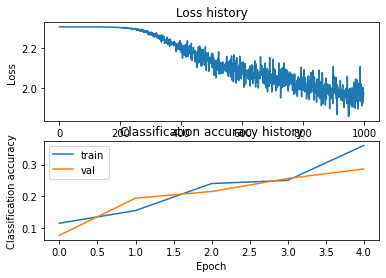

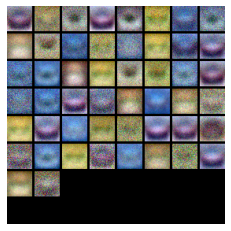

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  100
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302585
iteration 100 / 4000: loss 2.301745
iteration 200 / 4000: loss 2.294078
iteration 300 / 4000: loss 2.244220
iteration 400 / 4000: loss 2.155261
iteration 500 / 4000: loss 2.143466
iteration 600 / 4000: loss 2.080618
iteration 700 / 4000: loss 2.072903
iteration 800 / 4000: loss 1.989390
iteration 900 / 4000: loss 2.098664
iteration 1000 / 4000: loss 1.946036
iteration 1100 / 4000: loss 1.834911
iteration 1200 / 4000: loss 1.884956
iteration 1300 / 4000: loss 1.868887
iteration 1400 / 4000: loss 1.845262
iteration 1500 / 4000: loss 1.899481
iteration 1600 / 4000: loss 1.867504
iteration 1700 / 4000: loss 1.855577
iteration 1800 / 4000: loss 1.840761
iteration 1900 / 4000: loss 1.775306
iteration 2000 / 4000: loss 1.691774
iteration 2100 / 4000: loss 1.798465
iteration 2200 / 4000: loss 1.667732
iteration 2300 / 4000: loss 1.818328
iterati

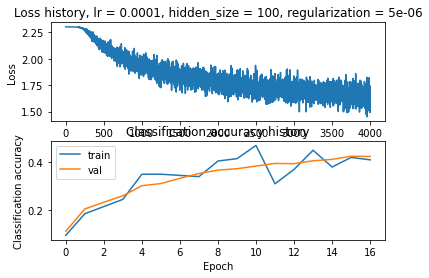

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  100
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302589
iteration 100 / 4000: loss 2.301427
iteration 200 / 4000: loss 2.293687
iteration 300 / 4000: loss 2.250468
iteration 400 / 4000: loss 2.177133
iteration 500 / 4000: loss 2.126632
iteration 600 / 4000: loss 2.091495
iteration 700 / 4000: loss 2.022483
iteration 800 / 4000: loss 1.975202
iteration 900 / 4000: loss 1.882789
iteration 1000 / 4000: loss 1.949459
iteration 1100 / 4000: loss 1.853426
iteration 1200 / 4000: loss 1.900327
iteration 1300 / 4000: loss 1.909180
iteration 1400 / 4000: loss 1.870340
iteration 1500 / 4000: loss 1.894764
iteration 1600 / 4000: loss 1.816335
iteration 1700 / 4000: loss 1.732764
iteration 1800 / 4000: loss 1.779308
iteration 1900 / 4000: loss 1.678151
iteration 2000 / 4000: loss 1.728607
iteration 2100 / 4000: loss 1.832296
iteration 2200 / 4000: loss 1.860302
iteration 2300 / 4000: loss 1.755170
iterat

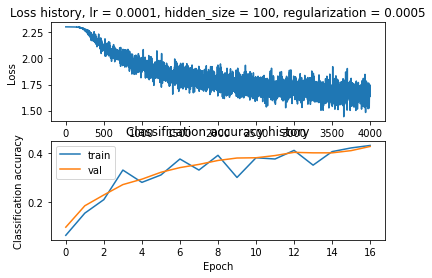

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  100
Regularization strenght:  0.05
iteration 0 / 4000: loss 2.302707
iteration 100 / 4000: loss 2.301823
iteration 200 / 4000: loss 2.292297
iteration 300 / 4000: loss 2.262481
iteration 400 / 4000: loss 2.179970
iteration 500 / 4000: loss 2.091084
iteration 600 / 4000: loss 2.055656
iteration 700 / 4000: loss 1.944372
iteration 800 / 4000: loss 1.979657
iteration 900 / 4000: loss 1.984059
iteration 1000 / 4000: loss 2.022576
iteration 1100 / 4000: loss 1.940089
iteration 1200 / 4000: loss 1.914508
iteration 1300 / 4000: loss 1.858843
iteration 1400 / 4000: loss 1.893145
iteration 1500 / 4000: loss 1.891378
iteration 1600 / 4000: loss 1.895353
iteration 1700 / 4000: loss 1.650504
iteration 1800 / 4000: loss 1.709565
iteration 1900 / 4000: loss 1.765479
iteration 2000 / 4000: loss 1.891362
iteration 2100 / 4000: loss 1.742496
iteration 2200 / 4000: loss 1.673561
iteration 2300 / 4000: loss 1.662526
iteratio

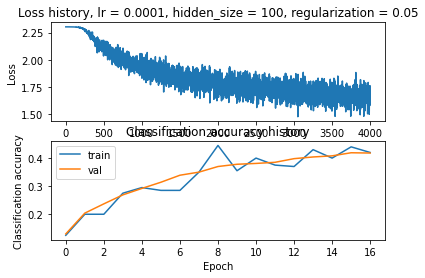

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  100
Regularization strenght:  0.1
iteration 0 / 4000: loss 2.302882
iteration 100 / 4000: loss 2.302246
iteration 200 / 4000: loss 2.296720
iteration 300 / 4000: loss 2.246935
iteration 400 / 4000: loss 2.181331
iteration 500 / 4000: loss 2.087011
iteration 600 / 4000: loss 2.095595
iteration 700 / 4000: loss 2.040045
iteration 800 / 4000: loss 2.008012
iteration 900 / 4000: loss 1.943964
iteration 1000 / 4000: loss 1.943272
iteration 1100 / 4000: loss 1.845312
iteration 1200 / 4000: loss 1.922373
iteration 1300 / 4000: loss 1.885704
iteration 1400 / 4000: loss 1.830135
iteration 1500 / 4000: loss 1.830658
iteration 1600 / 4000: loss 1.897644
iteration 1700 / 4000: loss 1.820011
iteration 1800 / 4000: loss 1.847086
iteration 1900 / 4000: loss 1.876177
iteration 2000 / 4000: loss 1.670131
iteration 2100 / 4000: loss 1.723817
iteration 2200 / 4000: loss 1.781826
iteration 2300 / 4000: loss 1.702788
iteration

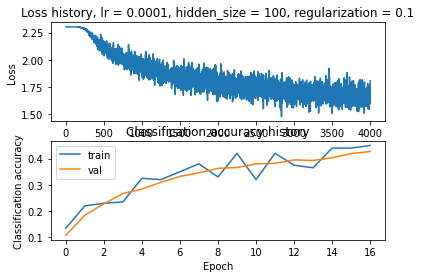

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  300
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302604
iteration 100 / 4000: loss 2.299663
iteration 200 / 4000: loss 2.278449
iteration 300 / 4000: loss 2.216140
iteration 400 / 4000: loss 2.136032
iteration 500 / 4000: loss 2.057062
iteration 600 / 4000: loss 1.990821
iteration 700 / 4000: loss 2.020390
iteration 800 / 4000: loss 1.963194
iteration 900 / 4000: loss 1.941863
iteration 1000 / 4000: loss 2.009512
iteration 1100 / 4000: loss 1.872179
iteration 1200 / 4000: loss 1.884536
iteration 1300 / 4000: loss 1.819716
iteration 1400 / 4000: loss 1.751698
iteration 1500 / 4000: loss 1.796100
iteration 1600 / 4000: loss 1.774343
iteration 1700 / 4000: loss 1.836336
iteration 1800 / 4000: loss 1.863494
iteration 1900 / 4000: loss 1.838408
iteration 2000 / 4000: loss 1.644399
iteration 2100 / 4000: loss 1.874704
iteration 2200 / 4000: loss 1.729196
iteration 2300 / 4000: loss 1.646047
iterati

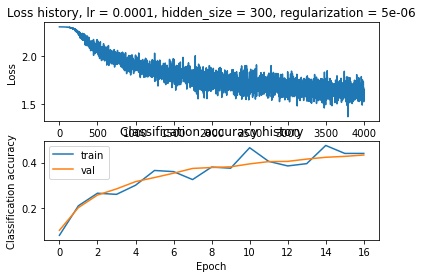

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  300
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302495
iteration 100 / 4000: loss 2.299256
iteration 200 / 4000: loss 2.269882
iteration 300 / 4000: loss 2.175888
iteration 400 / 4000: loss 2.128288
iteration 500 / 4000: loss 2.064006
iteration 600 / 4000: loss 2.025546
iteration 700 / 4000: loss 2.011946
iteration 800 / 4000: loss 1.986635
iteration 900 / 4000: loss 1.934504
iteration 1000 / 4000: loss 1.855716
iteration 1100 / 4000: loss 1.930041
iteration 1200 / 4000: loss 1.822122
iteration 1300 / 4000: loss 1.680265
iteration 1400 / 4000: loss 1.859095
iteration 1500 / 4000: loss 1.761198
iteration 1600 / 4000: loss 1.697324
iteration 1700 / 4000: loss 1.782160
iteration 1800 / 4000: loss 1.759058
iteration 1900 / 4000: loss 1.726569
iteration 2000 / 4000: loss 1.685851
iteration 2100 / 4000: loss 1.713040
iteration 2200 / 4000: loss 1.716291
iteration 2300 / 4000: loss 1.806945
iterat

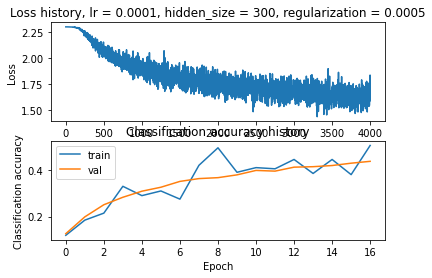

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  300
Regularization strenght:  0.05
iteration 0 / 4000: loss 2.303097
iteration 100 / 4000: loss 2.300152
iteration 200 / 4000: loss 2.270121
iteration 300 / 4000: loss 2.189905
iteration 400 / 4000: loss 2.116580
iteration 500 / 4000: loss 2.025568
iteration 600 / 4000: loss 1.990061
iteration 700 / 4000: loss 2.026722
iteration 800 / 4000: loss 1.872762
iteration 900 / 4000: loss 1.953993
iteration 1000 / 4000: loss 1.885093
iteration 1100 / 4000: loss 1.930828
iteration 1200 / 4000: loss 1.824185
iteration 1300 / 4000: loss 1.836839
iteration 1400 / 4000: loss 1.929578
iteration 1500 / 4000: loss 1.742224
iteration 1600 / 4000: loss 1.853711
iteration 1700 / 4000: loss 1.862744
iteration 1800 / 4000: loss 1.793149
iteration 1900 / 4000: loss 1.737787
iteration 2000 / 4000: loss 1.695978
iteration 2100 / 4000: loss 1.673657
iteration 2200 / 4000: loss 1.687882
iteration 2300 / 4000: loss 1.715496
iteratio

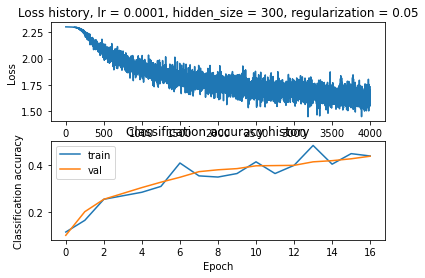

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  300
Regularization strenght:  0.1
iteration 0 / 4000: loss 2.303466
iteration 100 / 4000: loss 2.300889
iteration 200 / 4000: loss 2.273930
iteration 300 / 4000: loss 2.213959
iteration 400 / 4000: loss 2.082070
iteration 500 / 4000: loss 2.086122
iteration 600 / 4000: loss 2.037074
iteration 700 / 4000: loss 1.991000
iteration 800 / 4000: loss 1.967759
iteration 900 / 4000: loss 1.946567
iteration 1000 / 4000: loss 1.900340
iteration 1100 / 4000: loss 1.907421
iteration 1200 / 4000: loss 1.740633
iteration 1300 / 4000: loss 1.907380
iteration 1400 / 4000: loss 1.869901
iteration 1500 / 4000: loss 1.819740
iteration 1600 / 4000: loss 1.791320
iteration 1700 / 4000: loss 1.858549
iteration 1800 / 4000: loss 1.813971
iteration 1900 / 4000: loss 1.747158
iteration 2000 / 4000: loss 1.739365
iteration 2100 / 4000: loss 1.831696
iteration 2200 / 4000: loss 1.713418
iteration 2300 / 4000: loss 1.657803
iteration

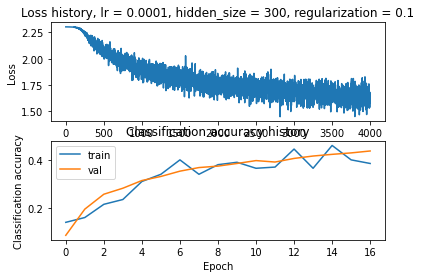

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  500
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302618
iteration 100 / 4000: loss 2.298967
iteration 200 / 4000: loss 2.268750
iteration 300 / 4000: loss 2.167142
iteration 400 / 4000: loss 2.115310
iteration 500 / 4000: loss 2.066076
iteration 600 / 4000: loss 1.956419
iteration 700 / 4000: loss 1.887916
iteration 800 / 4000: loss 1.994618
iteration 900 / 4000: loss 1.852956
iteration 1000 / 4000: loss 1.851297
iteration 1100 / 4000: loss 1.773915
iteration 1200 / 4000: loss 1.862690
iteration 1300 / 4000: loss 1.828832
iteration 1400 / 4000: loss 1.748345
iteration 1500 / 4000: loss 1.745270
iteration 1600 / 4000: loss 1.858767
iteration 1700 / 4000: loss 1.963406
iteration 1800 / 4000: loss 1.817260
iteration 1900 / 4000: loss 1.798003
iteration 2000 / 4000: loss 1.703516
iteration 2100 / 4000: loss 1.727339
iteration 2200 / 4000: loss 1.698722
iteration 2300 / 4000: loss 1.689568
iterati

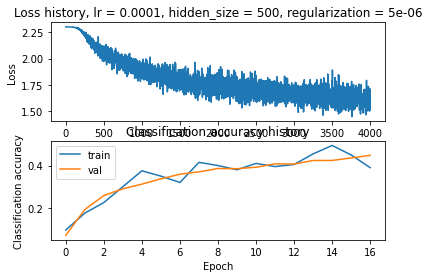

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  500
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302575
iteration 100 / 4000: loss 2.297737
iteration 200 / 4000: loss 2.251382
iteration 300 / 4000: loss 2.175303
iteration 400 / 4000: loss 2.130014
iteration 500 / 4000: loss 2.093558
iteration 600 / 4000: loss 1.930404
iteration 700 / 4000: loss 2.013475
iteration 800 / 4000: loss 1.928181
iteration 900 / 4000: loss 1.880467
iteration 1000 / 4000: loss 1.839244
iteration 1100 / 4000: loss 1.862422
iteration 1200 / 4000: loss 1.866294
iteration 1300 / 4000: loss 1.721473
iteration 1400 / 4000: loss 1.782963
iteration 1500 / 4000: loss 1.812280
iteration 1600 / 4000: loss 1.731467
iteration 1700 / 4000: loss 1.805194
iteration 1800 / 4000: loss 1.742722
iteration 1900 / 4000: loss 1.768089
iteration 2000 / 4000: loss 1.715147
iteration 2100 / 4000: loss 1.745777
iteration 2200 / 4000: loss 1.749140
iteration 2300 / 4000: loss 1.637775
iterat

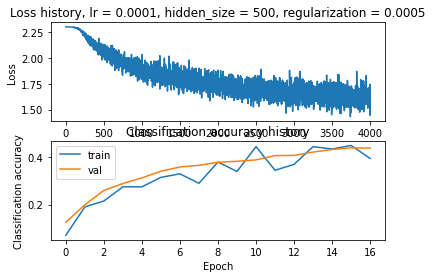

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  500
Regularization strenght:  0.05
iteration 0 / 4000: loss 2.303372
iteration 100 / 4000: loss 2.298669
iteration 200 / 4000: loss 2.263387
iteration 300 / 4000: loss 2.183851
iteration 400 / 4000: loss 2.110425
iteration 500 / 4000: loss 2.050579
iteration 600 / 4000: loss 1.986447
iteration 700 / 4000: loss 1.941274
iteration 800 / 4000: loss 1.946279
iteration 900 / 4000: loss 1.905308
iteration 1000 / 4000: loss 1.939731
iteration 1100 / 4000: loss 1.887479
iteration 1200 / 4000: loss 1.881649
iteration 1300 / 4000: loss 1.914094
iteration 1400 / 4000: loss 1.807311
iteration 1500 / 4000: loss 1.767307
iteration 1600 / 4000: loss 1.819650
iteration 1700 / 4000: loss 1.752391
iteration 1800 / 4000: loss 1.806238
iteration 1900 / 4000: loss 1.737141
iteration 2000 / 4000: loss 1.728752
iteration 2100 / 4000: loss 1.775421
iteration 2200 / 4000: loss 1.749090
iteration 2300 / 4000: loss 1.728000
iteratio

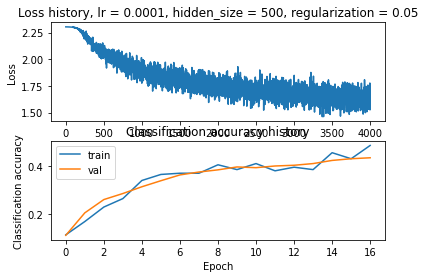

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  500
Regularization strenght:  0.1
iteration 0 / 4000: loss 2.304120
iteration 100 / 4000: loss 2.298639
iteration 200 / 4000: loss 2.263099
iteration 300 / 4000: loss 2.170456
iteration 400 / 4000: loss 2.120853
iteration 500 / 4000: loss 2.080874
iteration 600 / 4000: loss 2.040079
iteration 700 / 4000: loss 1.981160
iteration 800 / 4000: loss 2.002009
iteration 900 / 4000: loss 1.925006
iteration 1000 / 4000: loss 1.922046
iteration 1100 / 4000: loss 1.915558
iteration 1200 / 4000: loss 1.855486
iteration 1300 / 4000: loss 1.819964
iteration 1400 / 4000: loss 1.788748
iteration 1500 / 4000: loss 1.832733
iteration 1600 / 4000: loss 1.791659
iteration 1700 / 4000: loss 1.756045
iteration 1800 / 4000: loss 1.817958
iteration 1900 / 4000: loss 1.747765
iteration 2000 / 4000: loss 1.777753
iteration 2100 / 4000: loss 1.809010
iteration 2200 / 4000: loss 1.726428
iteration 2300 / 4000: loss 1.861142
iteration

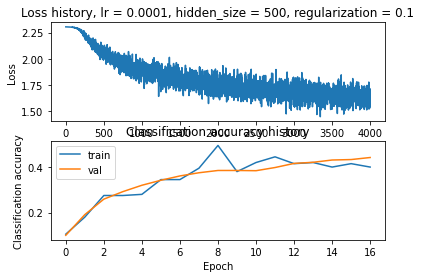

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  1000
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302602
iteration 100 / 4000: loss 2.295522
iteration 200 / 4000: loss 2.240029
iteration 300 / 4000: loss 2.183403
iteration 400 / 4000: loss 2.062707
iteration 500 / 4000: loss 2.129705
iteration 600 / 4000: loss 1.955770
iteration 700 / 4000: loss 1.913463
iteration 800 / 4000: loss 1.893328
iteration 900 / 4000: loss 1.841846
iteration 1000 / 4000: loss 1.872564
iteration 1100 / 4000: loss 1.869661
iteration 1200 / 4000: loss 1.872769
iteration 1300 / 4000: loss 1.809676
iteration 1400 / 4000: loss 1.817985
iteration 1500 / 4000: loss 1.755445
iteration 1600 / 4000: loss 1.701201
iteration 1700 / 4000: loss 1.761185
iteration 1800 / 4000: loss 1.736316
iteration 1900 / 4000: loss 1.794642
iteration 2000 / 4000: loss 1.678867
iteration 2100 / 4000: loss 1.833307
iteration 2200 / 4000: loss 1.780032
iteration 2300 / 4000: loss 1.596294
iterat

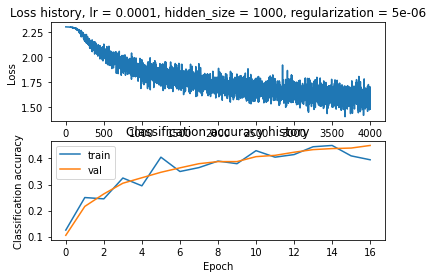

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  1000
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302579
iteration 100 / 4000: loss 2.295937
iteration 200 / 4000: loss 2.227826
iteration 300 / 4000: loss 2.181778
iteration 400 / 4000: loss 2.082648
iteration 500 / 4000: loss 1.994663
iteration 600 / 4000: loss 2.080673
iteration 700 / 4000: loss 1.918049
iteration 800 / 4000: loss 1.882324
iteration 900 / 4000: loss 1.934940
iteration 1000 / 4000: loss 1.817371
iteration 1100 / 4000: loss 1.865861
iteration 1200 / 4000: loss 1.956868
iteration 1300 / 4000: loss 1.821313
iteration 1400 / 4000: loss 1.728674
iteration 1500 / 4000: loss 1.863693
iteration 1600 / 4000: loss 1.719578
iteration 1700 / 4000: loss 1.803939
iteration 1800 / 4000: loss 1.717203
iteration 1900 / 4000: loss 1.664245
iteration 2000 / 4000: loss 1.629672
iteration 2100 / 4000: loss 1.668023
iteration 2200 / 4000: loss 1.630916
iteration 2300 / 4000: loss 1.713484
itera

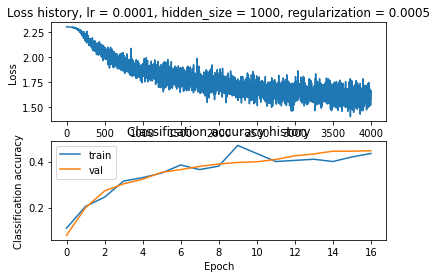

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  1000
Regularization strenght:  0.05
iteration 0 / 4000: loss 2.304121
iteration 100 / 4000: loss 2.291301
iteration 200 / 4000: loss 2.235493
iteration 300 / 4000: loss 2.145134
iteration 400 / 4000: loss 2.118815
iteration 500 / 4000: loss 1.975706
iteration 600 / 4000: loss 2.022066
iteration 700 / 4000: loss 1.925036
iteration 800 / 4000: loss 1.923235
iteration 900 / 4000: loss 1.894375
iteration 1000 / 4000: loss 1.928619
iteration 1100 / 4000: loss 1.867037
iteration 1200 / 4000: loss 1.727796
iteration 1300 / 4000: loss 1.743240
iteration 1400 / 4000: loss 1.804614
iteration 1500 / 4000: loss 1.837641
iteration 1600 / 4000: loss 1.790797
iteration 1700 / 4000: loss 1.798842
iteration 1800 / 4000: loss 1.695785
iteration 1900 / 4000: loss 1.768054
iteration 2000 / 4000: loss 1.627526
iteration 2100 / 4000: loss 1.668783
iteration 2200 / 4000: loss 1.719537
iteration 2300 / 4000: loss 1.654102
iterati

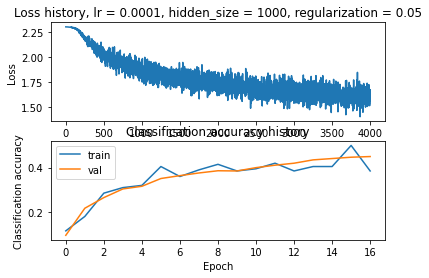

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  1000
Regularization strenght:  0.1
iteration 0 / 4000: loss 2.305732
iteration 100 / 4000: loss 2.296675
iteration 200 / 4000: loss 2.255864
iteration 300 / 4000: loss 2.163849
iteration 400 / 4000: loss 2.082720
iteration 500 / 4000: loss 2.055411
iteration 600 / 4000: loss 1.968001
iteration 700 / 4000: loss 1.961386
iteration 800 / 4000: loss 1.977510
iteration 900 / 4000: loss 1.897448
iteration 1000 / 4000: loss 1.928466
iteration 1100 / 4000: loss 1.916880
iteration 1200 / 4000: loss 1.772972
iteration 1300 / 4000: loss 1.805932
iteration 1400 / 4000: loss 1.914382
iteration 1500 / 4000: loss 1.746740
iteration 1600 / 4000: loss 1.820664
iteration 1700 / 4000: loss 1.704647
iteration 1800 / 4000: loss 1.676390
iteration 1900 / 4000: loss 1.859871
iteration 2000 / 4000: loss 1.654854
iteration 2100 / 4000: loss 1.655212
iteration 2200 / 4000: loss 1.806126
iteration 2300 / 4000: loss 1.725923
iteratio

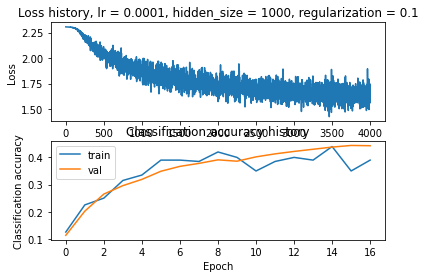

---------------------------------
Learning rate:  0.001
Size for hidden layer:  100
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302634
iteration 100 / 4000: loss 1.932312
iteration 200 / 4000: loss 1.732103
iteration 300 / 4000: loss 1.695007
iteration 400 / 4000: loss 1.576613
iteration 500 / 4000: loss 1.519814
iteration 600 / 4000: loss 1.504014
iteration 700 / 4000: loss 1.507072
iteration 800 / 4000: loss 1.523969
iteration 900 / 4000: loss 1.417900
iteration 1000 / 4000: loss 1.598046
iteration 1100 / 4000: loss 1.431657
iteration 1200 / 4000: loss 1.330606
iteration 1300 / 4000: loss 1.335369
iteration 1400 / 4000: loss 1.342386
iteration 1500 / 4000: loss 1.299981
iteration 1600 / 4000: loss 1.357989
iteration 1700 / 4000: loss 1.278298
iteration 1800 / 4000: loss 1.253667
iteration 1900 / 4000: loss 1.252329
iteration 2000 / 4000: loss 1.223865
iteration 2100 / 4000: loss 1.243568
iteration 2200 / 4000: loss 1.248188
iteration 2300 / 4000: loss 1.422013
iteratio

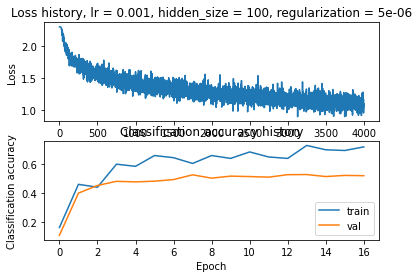

---------------------------------
Learning rate:  0.001
Size for hidden layer:  100
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302597
iteration 100 / 4000: loss 1.923054
iteration 200 / 4000: loss 1.736262
iteration 300 / 4000: loss 1.700443
iteration 400 / 4000: loss 1.592670
iteration 500 / 4000: loss 1.478259
iteration 600 / 4000: loss 1.396370
iteration 700 / 4000: loss 1.430954
iteration 800 / 4000: loss 1.487268
iteration 900 / 4000: loss 1.441018
iteration 1000 / 4000: loss 1.365005
iteration 1100 / 4000: loss 1.431076
iteration 1200 / 4000: loss 1.362100
iteration 1300 / 4000: loss 1.560305
iteration 1400 / 4000: loss 1.431377
iteration 1500 / 4000: loss 1.223172
iteration 1600 / 4000: loss 1.391326
iteration 1700 / 4000: loss 1.232226
iteration 1800 / 4000: loss 1.169481
iteration 1900 / 4000: loss 1.395613
iteration 2000 / 4000: loss 1.146341
iteration 2100 / 4000: loss 1.251480
iteration 2200 / 4000: loss 1.214835
iteration 2300 / 4000: loss 1.173114
iterati

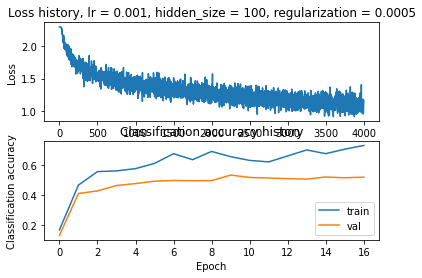

---------------------------------
Learning rate:  0.001
Size for hidden layer:  100
Regularization strenght:  0.05
iteration 0 / 4000: loss 2.302732
iteration 100 / 4000: loss 1.885569
iteration 200 / 4000: loss 1.858957
iteration 300 / 4000: loss 1.631376
iteration 400 / 4000: loss 1.437741
iteration 500 / 4000: loss 1.487601
iteration 600 / 4000: loss 1.610037
iteration 700 / 4000: loss 1.558256
iteration 800 / 4000: loss 1.452172
iteration 900 / 4000: loss 1.284497
iteration 1000 / 4000: loss 1.599562
iteration 1100 / 4000: loss 1.433876
iteration 1200 / 4000: loss 1.546401
iteration 1300 / 4000: loss 1.471694
iteration 1400 / 4000: loss 1.386960
iteration 1500 / 4000: loss 1.474732
iteration 1600 / 4000: loss 1.241230
iteration 1700 / 4000: loss 1.449007
iteration 1800 / 4000: loss 1.289589
iteration 1900 / 4000: loss 1.388231
iteration 2000 / 4000: loss 1.360201
iteration 2100 / 4000: loss 1.306801
iteration 2200 / 4000: loss 1.299058
iteration 2300 / 4000: loss 1.332532
iteration

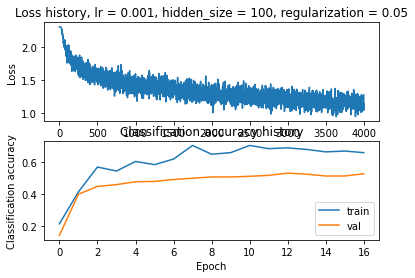

---------------------------------
Learning rate:  0.001
Size for hidden layer:  100
Regularization strenght:  0.1
iteration 0 / 4000: loss 2.302872
iteration 100 / 4000: loss 1.883723
iteration 200 / 4000: loss 1.727180
iteration 300 / 4000: loss 1.638615
iteration 400 / 4000: loss 1.687772
iteration 500 / 4000: loss 1.658929
iteration 600 / 4000: loss 1.510707
iteration 700 / 4000: loss 1.553762
iteration 800 / 4000: loss 1.371792
iteration 900 / 4000: loss 1.442704
iteration 1000 / 4000: loss 1.486524
iteration 1100 / 4000: loss 1.504165
iteration 1200 / 4000: loss 1.528346
iteration 1300 / 4000: loss 1.262340
iteration 1400 / 4000: loss 1.320135
iteration 1500 / 4000: loss 1.359415
iteration 1600 / 4000: loss 1.413823
iteration 1700 / 4000: loss 1.322888
iteration 1800 / 4000: loss 1.261873
iteration 1900 / 4000: loss 1.305790
iteration 2000 / 4000: loss 1.565348
iteration 2100 / 4000: loss 1.398639
iteration 2200 / 4000: loss 1.350761
iteration 2300 / 4000: loss 1.300332
iteration 

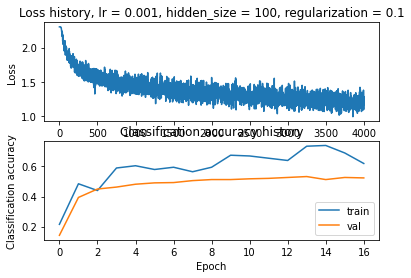

---------------------------------
Learning rate:  0.001
Size for hidden layer:  300
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302545
iteration 100 / 4000: loss 1.934754
iteration 200 / 4000: loss 1.795994
iteration 300 / 4000: loss 1.597989
iteration 400 / 4000: loss 1.693866
iteration 500 / 4000: loss 1.612166
iteration 600 / 4000: loss 1.450683
iteration 700 / 4000: loss 1.562039
iteration 800 / 4000: loss 1.621249
iteration 900 / 4000: loss 1.508150
iteration 1000 / 4000: loss 1.319792
iteration 1100 / 4000: loss 1.353994
iteration 1200 / 4000: loss 1.356558
iteration 1300 / 4000: loss 1.261409
iteration 1400 / 4000: loss 1.269924
iteration 1500 / 4000: loss 1.358712
iteration 1600 / 4000: loss 1.396228
iteration 1700 / 4000: loss 1.403779
iteration 1800 / 4000: loss 1.193814
iteration 1900 / 4000: loss 1.404587
iteration 2000 / 4000: loss 1.103631
iteration 2100 / 4000: loss 1.232656
iteration 2200 / 4000: loss 1.100127
iteration 2300 / 4000: loss 1.100018
iteratio

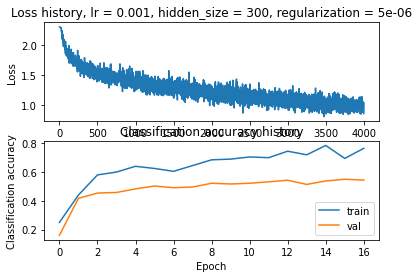

---------------------------------
Learning rate:  0.001
Size for hidden layer:  300
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302569
iteration 100 / 4000: loss 1.811135
iteration 200 / 4000: loss 1.721188
iteration 300 / 4000: loss 1.701826
iteration 400 / 4000: loss 1.585595
iteration 500 / 4000: loss 1.637080
iteration 600 / 4000: loss 1.584792
iteration 700 / 4000: loss 1.451828
iteration 800 / 4000: loss 1.500659
iteration 900 / 4000: loss 1.514899
iteration 1000 / 4000: loss 1.316611
iteration 1100 / 4000: loss 1.265199
iteration 1200 / 4000: loss 1.260531
iteration 1300 / 4000: loss 1.314921
iteration 1400 / 4000: loss 1.350322
iteration 1500 / 4000: loss 1.223894
iteration 1600 / 4000: loss 1.262680
iteration 1700 / 4000: loss 1.160104
iteration 1800 / 4000: loss 1.169314
iteration 1900 / 4000: loss 1.031253
iteration 2000 / 4000: loss 1.322969
iteration 2100 / 4000: loss 1.177587
iteration 2200 / 4000: loss 1.151500
iteration 2300 / 4000: loss 1.146335
iterati

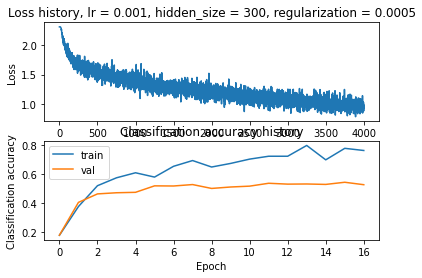

---------------------------------
Learning rate:  0.001
Size for hidden layer:  300
Regularization strenght:  0.05
iteration 0 / 4000: loss 2.303034
iteration 100 / 4000: loss 1.877849
iteration 200 / 4000: loss 1.663236
iteration 300 / 4000: loss 1.699291
iteration 400 / 4000: loss 1.576037
iteration 500 / 4000: loss 1.520267
iteration 600 / 4000: loss 1.474574
iteration 700 / 4000: loss 1.533570
iteration 800 / 4000: loss 1.456949
iteration 900 / 4000: loss 1.464191
iteration 1000 / 4000: loss 1.442400
iteration 1100 / 4000: loss 1.398620
iteration 1200 / 4000: loss 1.331930
iteration 1300 / 4000: loss 1.131870
iteration 1400 / 4000: loss 1.323015
iteration 1500 / 4000: loss 1.380693
iteration 1600 / 4000: loss 1.264760
iteration 1700 / 4000: loss 1.312234
iteration 1800 / 4000: loss 1.310155
iteration 1900 / 4000: loss 1.111934
iteration 2000 / 4000: loss 1.260593
iteration 2100 / 4000: loss 1.173927
iteration 2200 / 4000: loss 1.189693
iteration 2300 / 4000: loss 1.231339
iteration

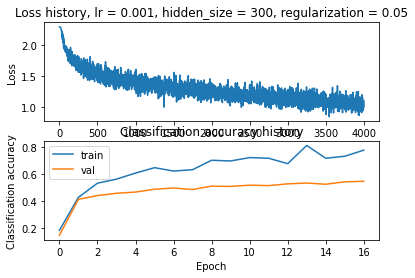

---------------------------------
Learning rate:  0.001
Size for hidden layer:  300
Regularization strenght:  0.1
iteration 0 / 4000: loss 2.303369
iteration 100 / 4000: loss 1.868541
iteration 200 / 4000: loss 1.712544
iteration 300 / 4000: loss 1.668766
iteration 400 / 4000: loss 1.595919
iteration 500 / 4000: loss 1.550087
iteration 600 / 4000: loss 1.600887
iteration 700 / 4000: loss 1.334651
iteration 800 / 4000: loss 1.488768
iteration 900 / 4000: loss 1.465820
iteration 1000 / 4000: loss 1.281987
iteration 1100 / 4000: loss 1.461021
iteration 1200 / 4000: loss 1.497468
iteration 1300 / 4000: loss 1.437753
iteration 1400 / 4000: loss 1.430819
iteration 1500 / 4000: loss 1.280848
iteration 1600 / 4000: loss 1.513751
iteration 1700 / 4000: loss 1.408099
iteration 1800 / 4000: loss 1.228706
iteration 1900 / 4000: loss 1.256856
iteration 2000 / 4000: loss 1.223710
iteration 2100 / 4000: loss 1.295570
iteration 2200 / 4000: loss 1.158747
iteration 2300 / 4000: loss 1.112878
iteration 

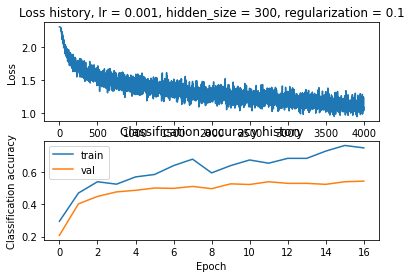

---------------------------------
Learning rate:  0.001
Size for hidden layer:  500
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302569
iteration 100 / 4000: loss 1.923508
iteration 200 / 4000: loss 1.814471
iteration 300 / 4000: loss 1.561909
iteration 400 / 4000: loss 1.623030
iteration 500 / 4000: loss 1.509144
iteration 600 / 4000: loss 1.441293
iteration 700 / 4000: loss 1.497307
iteration 800 / 4000: loss 1.297683
iteration 900 / 4000: loss 1.470841
iteration 1000 / 4000: loss 1.443536
iteration 1100 / 4000: loss 1.282103
iteration 1200 / 4000: loss 1.334366
iteration 1300 / 4000: loss 1.317973
iteration 1400 / 4000: loss 1.320707
iteration 1500 / 4000: loss 1.219398
iteration 1600 / 4000: loss 1.394926
iteration 1700 / 4000: loss 1.118892
iteration 1800 / 4000: loss 1.240878
iteration 1900 / 4000: loss 1.139865
iteration 2000 / 4000: loss 1.101983
iteration 2100 / 4000: loss 1.250341
iteration 2200 / 4000: loss 1.255625
iteration 2300 / 4000: loss 1.125891
iteratio

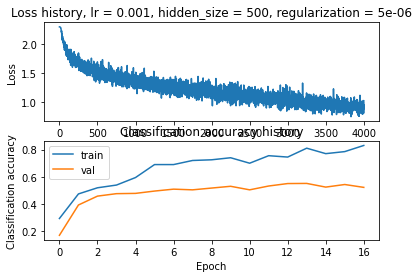

---------------------------------
Learning rate:  0.001
Size for hidden layer:  500
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302504
iteration 100 / 4000: loss 1.816867
iteration 200 / 4000: loss 1.750199
iteration 300 / 4000: loss 1.662728
iteration 400 / 4000: loss 1.478204
iteration 500 / 4000: loss 1.575156
iteration 600 / 4000: loss 1.493445
iteration 700 / 4000: loss 1.459313
iteration 800 / 4000: loss 1.440349
iteration 900 / 4000: loss 1.418285
iteration 1000 / 4000: loss 1.258984
iteration 1100 / 4000: loss 1.317184
iteration 1200 / 4000: loss 1.293134
iteration 1300 / 4000: loss 1.299201
iteration 1400 / 4000: loss 1.340821
iteration 1500 / 4000: loss 1.236584
iteration 1600 / 4000: loss 1.175158
iteration 1700 / 4000: loss 1.175918
iteration 1800 / 4000: loss 1.291153
iteration 1900 / 4000: loss 1.189103
iteration 2000 / 4000: loss 1.236792
iteration 2100 / 4000: loss 1.080260
iteration 2200 / 4000: loss 1.352889
iteration 2300 / 4000: loss 1.128943
iterati

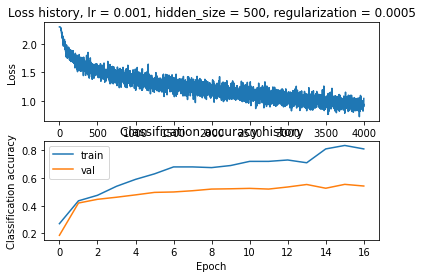

---------------------------------
Learning rate:  0.001
Size for hidden layer:  500
Regularization strenght:  0.05
iteration 0 / 4000: loss 2.303390
iteration 100 / 4000: loss 1.826160
iteration 200 / 4000: loss 1.735140
iteration 300 / 4000: loss 1.750368
iteration 400 / 4000: loss 1.643817
iteration 500 / 4000: loss 1.447675
iteration 600 / 4000: loss 1.542156
iteration 700 / 4000: loss 1.455687
iteration 800 / 4000: loss 1.371607
iteration 900 / 4000: loss 1.402310
iteration 1000 / 4000: loss 1.249923
iteration 1100 / 4000: loss 1.391807
iteration 1200 / 4000: loss 1.288818
iteration 1300 / 4000: loss 1.228871
iteration 1400 / 4000: loss 1.262006
iteration 1500 / 4000: loss 1.430743
iteration 1600 / 4000: loss 1.237144
iteration 1700 / 4000: loss 1.289953
iteration 1800 / 4000: loss 1.214895
iteration 1900 / 4000: loss 1.308083
iteration 2000 / 4000: loss 1.224696
iteration 2100 / 4000: loss 1.245562
iteration 2200 / 4000: loss 1.148979
iteration 2300 / 4000: loss 1.302384
iteration

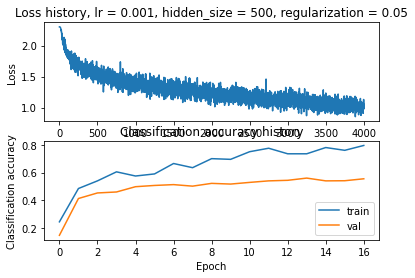

---------------------------------
Learning rate:  0.001
Size for hidden layer:  500
Regularization strenght:  0.1
iteration 0 / 4000: loss 2.304175
iteration 100 / 4000: loss 1.885001
iteration 200 / 4000: loss 1.808693
iteration 300 / 4000: loss 1.561506
iteration 400 / 4000: loss 1.644459
iteration 500 / 4000: loss 1.419712
iteration 600 / 4000: loss 1.533584
iteration 700 / 4000: loss 1.368999
iteration 800 / 4000: loss 1.580475
iteration 900 / 4000: loss 1.457551
iteration 1000 / 4000: loss 1.499079
iteration 1100 / 4000: loss 1.287920
iteration 1200 / 4000: loss 1.367563
iteration 1300 / 4000: loss 1.264050
iteration 1400 / 4000: loss 1.337544
iteration 1500 / 4000: loss 1.321143
iteration 1600 / 4000: loss 1.533087
iteration 1700 / 4000: loss 1.449329
iteration 1800 / 4000: loss 1.289870
iteration 1900 / 4000: loss 1.206933
iteration 2000 / 4000: loss 1.187594
iteration 2100 / 4000: loss 1.354656
iteration 2200 / 4000: loss 1.211079
iteration 2300 / 4000: loss 1.192828
iteration 

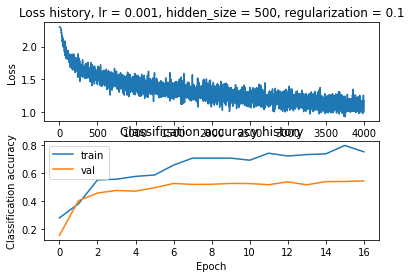

---------------------------------
Learning rate:  0.001
Size for hidden layer:  1000
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302630
iteration 100 / 4000: loss 1.896101
iteration 200 / 4000: loss 1.773060
iteration 300 / 4000: loss 1.682323
iteration 400 / 4000: loss 1.583423
iteration 500 / 4000: loss 1.574506
iteration 600 / 4000: loss 1.452542
iteration 700 / 4000: loss 1.411966
iteration 800 / 4000: loss 1.362211
iteration 900 / 4000: loss 1.262978
iteration 1000 / 4000: loss 1.322096
iteration 1100 / 4000: loss 1.261671
iteration 1200 / 4000: loss 1.343303
iteration 1300 / 4000: loss 1.395987
iteration 1400 / 4000: loss 1.311820
iteration 1500 / 4000: loss 1.100111
iteration 1600 / 4000: loss 1.363243
iteration 1700 / 4000: loss 1.220976
iteration 1800 / 4000: loss 1.164935
iteration 1900 / 4000: loss 1.146456
iteration 2000 / 4000: loss 1.172319
iteration 2100 / 4000: loss 1.143081
iteration 2200 / 4000: loss 1.143806
iteration 2300 / 4000: loss 1.091657
iterati

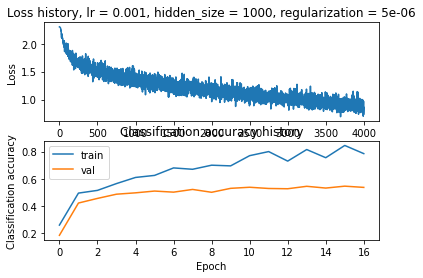

---------------------------------
Learning rate:  0.001
Size for hidden layer:  1000
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302675
iteration 100 / 4000: loss 1.787180
iteration 200 / 4000: loss 1.653671
iteration 300 / 4000: loss 1.741493
iteration 400 / 4000: loss 1.526325
iteration 500 / 4000: loss 1.465181
iteration 600 / 4000: loss 1.459260
iteration 700 / 4000: loss 1.398767
iteration 800 / 4000: loss 1.397048
iteration 900 / 4000: loss 1.405478
iteration 1000 / 4000: loss 1.281979
iteration 1100 / 4000: loss 1.371944
iteration 1200 / 4000: loss 1.367309
iteration 1300 / 4000: loss 1.290812
iteration 1400 / 4000: loss 1.184195
iteration 1500 / 4000: loss 1.273203
iteration 1600 / 4000: loss 1.354047
iteration 1700 / 4000: loss 1.289020
iteration 1800 / 4000: loss 1.383983
iteration 1900 / 4000: loss 1.127984
iteration 2000 / 4000: loss 1.234676
iteration 2100 / 4000: loss 1.162120
iteration 2200 / 4000: loss 1.110196
iteration 2300 / 4000: loss 1.102839
iterat

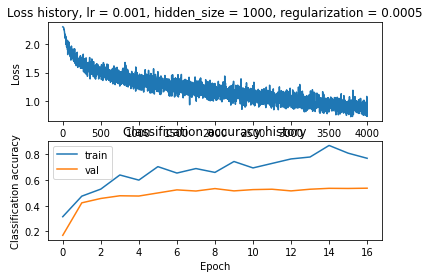

---------------------------------
Learning rate:  0.001
Size for hidden layer:  1000
Regularization strenght:  0.05
iteration 0 / 4000: loss 2.304147
iteration 100 / 4000: loss 1.833991
iteration 200 / 4000: loss 1.634748
iteration 300 / 4000: loss 1.638313
iteration 400 / 4000: loss 1.600318
iteration 500 / 4000: loss 1.598747
iteration 600 / 4000: loss 1.415863
iteration 700 / 4000: loss 1.563064
iteration 800 / 4000: loss 1.509986
iteration 900 / 4000: loss 1.262285
iteration 1000 / 4000: loss 1.472378
iteration 1100 / 4000: loss 1.304163
iteration 1200 / 4000: loss 1.479968
iteration 1300 / 4000: loss 1.171717
iteration 1400 / 4000: loss 1.114423
iteration 1500 / 4000: loss 1.284620
iteration 1600 / 4000: loss 1.387867
iteration 1700 / 4000: loss 1.281194
iteration 1800 / 4000: loss 1.349740
iteration 1900 / 4000: loss 1.213637
iteration 2000 / 4000: loss 1.198516
iteration 2100 / 4000: loss 1.204105
iteration 2200 / 4000: loss 1.241182
iteration 2300 / 4000: loss 1.085750
iteratio

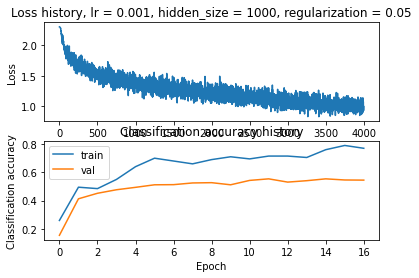

---------------------------------
Learning rate:  0.001
Size for hidden layer:  1000
Regularization strenght:  0.1
iteration 0 / 4000: loss 2.305565
iteration 100 / 4000: loss 1.873717
iteration 200 / 4000: loss 1.736206
iteration 300 / 4000: loss 1.615798
iteration 400 / 4000: loss 1.595014
iteration 500 / 4000: loss 1.563594
iteration 600 / 4000: loss 1.463756
iteration 700 / 4000: loss 1.515577
iteration 800 / 4000: loss 1.527707
iteration 900 / 4000: loss 1.405160
iteration 1000 / 4000: loss 1.345820
iteration 1100 / 4000: loss 1.331274
iteration 1200 / 4000: loss 1.358593
iteration 1300 / 4000: loss 1.396486
iteration 1400 / 4000: loss 1.343583
iteration 1500 / 4000: loss 1.363572
iteration 1600 / 4000: loss 1.287148
iteration 1700 / 4000: loss 1.243209
iteration 1800 / 4000: loss 1.343917
iteration 1900 / 4000: loss 1.276035
iteration 2000 / 4000: loss 1.261218
iteration 2100 / 4000: loss 1.296315
iteration 2200 / 4000: loss 1.257114
iteration 2300 / 4000: loss 1.368879
iteration

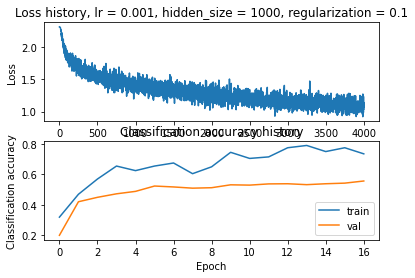

---------------------------------
Learning rate:  0.1
Size for hidden layer:  100
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302579


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss nan
iteration 2800 / 4000: loss nan
iteration 2900 / 4000: loss nan
iteration 3000 / 4000: loss nan
iteration 3100 / 4000: loss nan
iteration 3200 / 

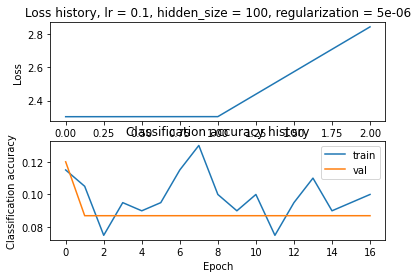

---------------------------------
Learning rate:  0.1
Size for hidden layer:  100
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302562
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss 

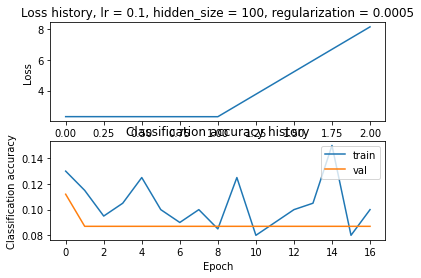

---------------------------------
Learning rate:  0.1
Size for hidden layer:  100
Regularization strenght:  0.05
iteration 0 / 4000: loss 2.302765
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss na

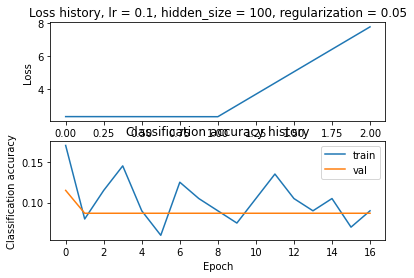

---------------------------------
Learning rate:  0.1
Size for hidden layer:  100
Regularization strenght:  0.1
iteration 0 / 4000: loss 2.302906
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss nan

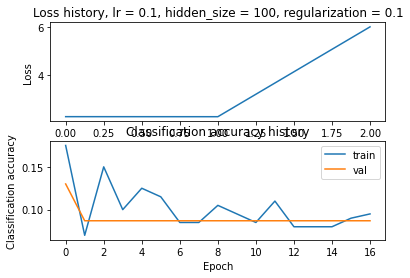

---------------------------------
Learning rate:  0.1
Size for hidden layer:  300
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302569
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss n

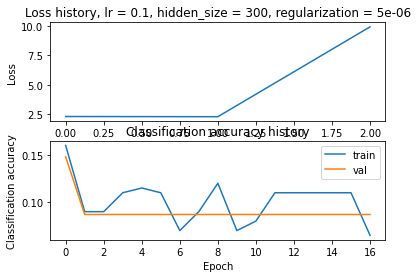

---------------------------------
Learning rate:  0.1
Size for hidden layer:  300
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302655
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss 

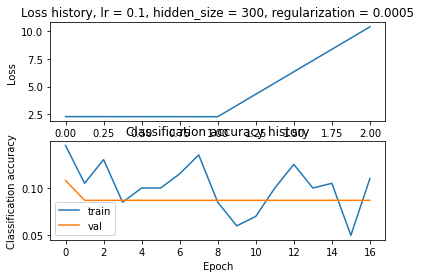

---------------------------------
Learning rate:  0.1
Size for hidden layer:  300
Regularization strenght:  0.05
iteration 0 / 4000: loss 2.303106
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss na

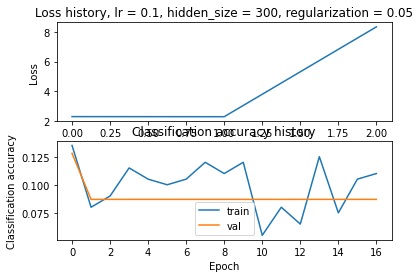

---------------------------------
Learning rate:  0.1
Size for hidden layer:  300
Regularization strenght:  0.1
iteration 0 / 4000: loss 2.303526
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss nan

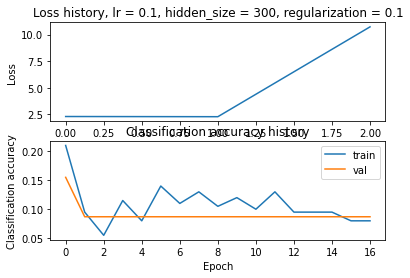

---------------------------------
Learning rate:  0.1
Size for hidden layer:  500
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302543
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss n

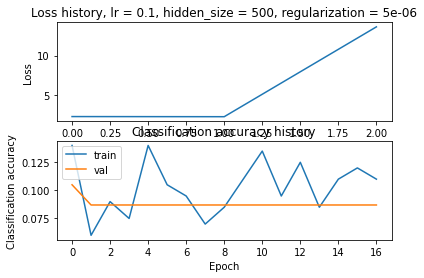

---------------------------------
Learning rate:  0.1
Size for hidden layer:  500
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302585
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss 

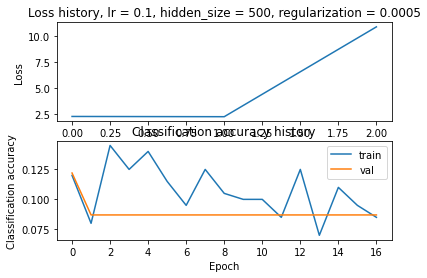

---------------------------------
Learning rate:  0.1
Size for hidden layer:  500
Regularization strenght:  0.05
iteration 0 / 4000: loss 2.303288
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss na

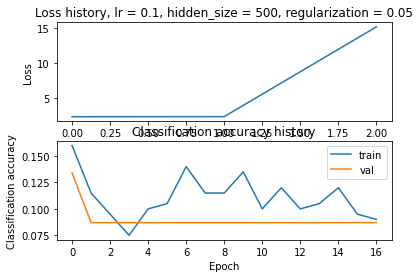

---------------------------------
Learning rate:  0.1
Size for hidden layer:  500
Regularization strenght:  0.1
iteration 0 / 4000: loss 2.304164
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss nan

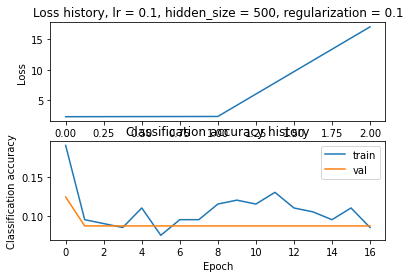

---------------------------------
Learning rate:  0.1
Size for hidden layer:  1000
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302530
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss 

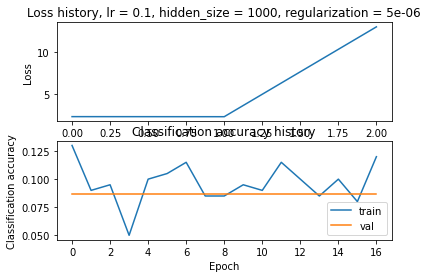

---------------------------------
Learning rate:  0.1
Size for hidden layer:  1000
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302634
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss

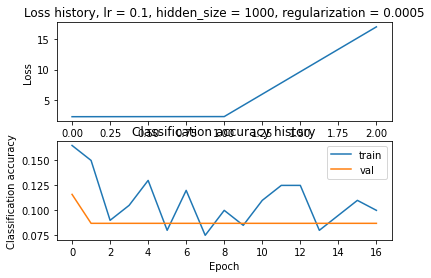

---------------------------------
Learning rate:  0.1
Size for hidden layer:  1000
Regularization strenght:  0.05
iteration 0 / 4000: loss 2.304066
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss n

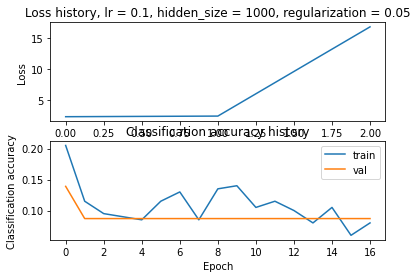

---------------------------------
Learning rate:  0.1
Size for hidden layer:  1000
Regularization strenght:  0.1
iteration 0 / 4000: loss 2.305807
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss na

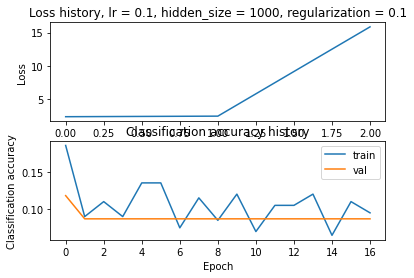

Best learning rate:  0.001
Best size for hidden layer:  500
Best regularization strenght:  0.05
iteration 0 / 20000: loss 2.303351
iteration 100 / 20000: loss 1.975583
iteration 200 / 20000: loss 1.707082
iteration 300 / 20000: loss 1.705813
iteration 400 / 20000: loss 1.641231
iteration 500 / 20000: loss 1.434462
iteration 600 / 20000: loss 1.422313
iteration 700 / 20000: loss 1.368873
iteration 800 / 20000: loss 1.364017
iteration 900 / 20000: loss 1.458500
iteration 1000 / 20000: loss 1.381162
iteration 1100 / 20000: loss 1.349042
iteration 1200 / 20000: loss 1.239956
iteration 1300 / 20000: loss 1.367393
iteration 1400 / 20000: loss 1.286205
iteration 1500 / 20000: loss 1.283828
iteration 1600 / 20000: loss 1.265313
iteration 1700 / 20000: loss 1.288624
iteration 1800 / 20000: loss 1.260074
iteration 1900 / 20000: loss 1.217158
iteration 2000 / 20000: loss 1.353445
iteration 2100 / 20000: loss 1.166014
iteration 2200 / 20000: loss 1.115095
iteration 2300 / 20000: loss 1.282934
iter

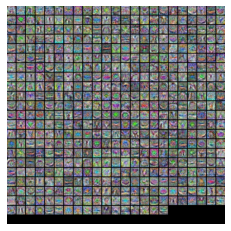

Test accuracy:  0.551


In [17]:
def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

# # Load the data
# Now that you have implemented a two-layer network that passes
# gradient checks and works on toy data, it's time to load up our favorite
# CIFAR-10 data so we can use it to train a classifier on a real dataset.
# Invoke the get_CIFAR10_data function to get our data.

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Visualize some images to get a feel for the data
plt.imshow(visualize_grid(X_train[:100, :].reshape(100, 32,32, 3), padding=3).astype('uint8'))
plt.gca().axis('off')
plt.show()

# # Train a network
# To train our network we will use SGD. In addition, we will
# adjust the learning rate with an exponential learning rate schedule as
# optimization proceeds; after each epoch, we will reduce the learning rate by
# multiplying it by a decay rate.

input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNetv4(input_size, hidden_size, num_classes)
# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# # Debug the training
# With the default parameters we provided above, you should get a validation
# accuracy of about 0.29 on the validation set. This isn't very good.
#
# One strategy for getting insight into what's wrong is to plot the loss
# function and the accuracies on the training and validation sets during
# optimization.
#
# Another strategy is to visualize the weights that were learned in the first
# layer of the network. In most neural networks trained on visual data, the
# first layer weights typically show some visible structure when visualized.

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()


# Visualize the weights of the network

show_net_weights(net)

# # Tune your hyperparameters
#
# **What's wrong?**. Looking at the visualizations above, we see that the loss
# is decreasing more or less linearly, which seems to suggest that the learning
# rate may be too low. Moreover, there is no gap between the training and
# validation accuracy, suggesting that the model we used has low capacity, and
# that we should increase its size. On the other hand, with a very large model
# we would expect to see more overfitting, which would manifest itself as a
# very large gap between the training and validation accuracy.
#
# **Tuning**. Tuning the hyperparameters and developing intuition for how they
# affect the final performance is a large part of using Neural Networks, so we
# want you to get a lot of practice. Below, you should experiment with
# different values of the various hyperparameters, including hidden layer size,
# learning rate, numer of training epochs, and regularization strength. You
# might also consider tuning the learning rate decay, but you should be able to
# get good performance using the default value.
#
# **Approximate results**. You should be aim to achieve a classification
# accuracy of greater than 48% on the validation set. Our best network gets
# over 52% on the validation set.
#
# **Experiment**: You goal in this exercise is to get as good of a result on
# CIFAR-10 as you can (52% could serve as a reference), with a fully-connected
# Neural Network. Feel free implement your own techniques (e.g. PCA to reduce
# dimensionality, or adding dropout, or adding features to the solver, etc.).

# **Explain your hyperparameter tuning process in the report.**

best_net = None # store the best model into this

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
best_acc = 0.
best_lr = None
best_reg = 0.
best_hidden_size = None
learning_rates = [1e-4, 1e-3, 1e-1]
hidden_sizes = [100, 300, 500, 1000]
reg_strength = [5e-6, 5e-4, 0.05, 0.1] 

for learning_rate in learning_rates:
    for hidden_size in hidden_sizes:
        for reg in reg_strength:
            print("---------------------------------")
            print("Learning rate: ", learning_rate)
            print("Size for hidden layer: ", hidden_size)
            print("Regularization strenght: ", reg)

            input_size = 32 * 32 * 3
            num_classes = 10
            net = TwoLayerNetv4(input_size, hidden_size, num_classes)
            # Train the network
            stats = net.train(X_train, y_train, X_val, y_val,
                        num_iters=4000, batch_size=200,
                        learning_rate=learning_rate, learning_rate_decay=0.95,
                        reg = reg, verbose=True)

            # Predict on the validation set
            val_acc = (net.predict(X_val) == y_val).mean()
            print('Validation accuracy: ', val_acc)

            if val_acc > best_acc:
                best_acc = val_acc
                best_net = net
                best_lr = learning_rate
                best_hidden_size = hidden_size
                best_reg = reg

            # Plot the loss function and train / validation accuracies
            plt.subplot(2, 1, 1)
            plt.plot(stats['loss_history'])
            plt.title('Loss history, lr = {}, hidden_size = {}, regularization = {}'.format(learning_rate, hidden_size, reg))
            plt.xlabel('Iteration')
            plt.ylabel('Loss')

            plt.subplot(2, 1, 2)
            plt.plot(stats['train_acc_history'], label='train')
            plt.plot(stats['val_acc_history'], label='val')
            plt.title('Classification accuracy history')
            plt.xlabel('Epoch')
            plt.ylabel('Classification accuracy')
            plt.legend()
            plt.show()

print("Best learning rate: ", best_lr)
print("Best size for hidden layer: ", best_hidden_size)
print("Best regularization strenght: ", best_reg)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

best_net = TwoLayerNetv4(input_size, best_hidden_size, num_classes)
# visualize the weights of the best network

stats = best_net.train(X_train, y_train, X_val, y_val,
            num_iters=20000, batch_size=200,
            learning_rate=best_lr, learning_rate_decay=0.90,
            reg=best_reg, verbose=True)

# Predict on the validation set
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)
show_net_weights(best_net)


# # Run on the test set
# When you are done experimenting, you should evaluate your final trained
# network on the test set; you should get above 48%.

test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

# Observations:

We trained with different values for learning rate, hidden size and regularisation strenght as indicated. 

1. The best accuracy is 0.551 on test dataset. The lr = 0.001, hidden size = 500 and reg strength is 0.05.
2. Also, if the number of hidden size is increaisng, for a fixed lr, the accuracy is slightly improving. 
3. One interesting aspect is that for the highest learning rate tested, in our case 0.1, we got numerical overflow. This may be expected due to vanishing / exploding gradinets.

### Question 4: Implement multi-layer perceptron using PyTorch library (10 points)

So far, we have implemented a two-layer network by explicitly writing down the expressions for the forward and backward computations and training algorithms using simple matrix multiplication primitives from the NumPy library.

However there are many libraries available designed make experimenting with neural networks faster by abstracting away the details into re-usable modules. One such popular open-source library is PyTorch (https://pytorch.org/). In this final question we will use the PyTorch library to implement the same two-layer network we did before and train it on the Cifar-10 dataset. However, extending a two-layer network to a three or four layered one is a matter of changing two-three lines of code using PyTorch. We will take advantage of this to experiment with deeper networks to improve the performance on the CIFAR-10 classification.

To install the pytorch library follow the instruction in
https://pytorch.org/get-started/locally/ . If you have access to a Graphics Processing
Unit (GPU), you can install the gpu verison and run the exercise on GPU for faster run
times. If not, you can install the cpu version (select cuda version None) and run on the
cpu. Having gpu access is not necessary to complete the exercise.  There are good tutorials
for getting started with pytorch on their website (https://pytorch.org/tutorials/).

a) Complete the code to implement a multi-layer perceptron network in the class
`MultiLayerPerceptron`. This includes instantiating the
required layers from `torch.nn` and writing the code for forward pass. Initially you 
should write the code for the same two-layer network we have seen before.
(3 points)

In [11]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import sys

def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 32 * 32 * 3
hidden_size = [50]
num_classes = 10
num_epochs = 20
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
train = True

#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
norm_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=False)

test_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                          train=False,
                                          transform=norm_transform
                                          )
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Using device: cuda


In [12]:
#======================================================================================
# Q4: Implementing multi-layer perceptron in PyTorch
#======================================================================================
# So far we have implemented a two-layer network using numpy by explicitly
# writing down the forward computation and deriving and implementing the
# equations for backward computation. This process can be tedious to extend to
# large network architectures
#
# Popular deep-learining libraries like PyTorch and Tensorflow allow us to
# quickly implement complicated neural network architectures. They provide
# pre-defined layers which can be used as building blocks to define our
# network. They also enable automatic-differentiation, which allows us to
# define only the forward pass and let the libraries perform back-propagation
# using automatic differentiation.
#
# In this question we will implement a multi-layer perceptron using the PyTorch
# library.  Please complete the code for the MultiLayerPerceptron, training and
# evaluating the model. Once you can train the two layer model, experiment with
# adding more layers and
#--------------------------------------------------------------------------------------

#-------------------------------------------------
# Fully connected neural network with one hidden layer
#-------------------------------------------------
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        #################################################################################
        # TODO: Initialize the modules required to implement the mlp with given layer   #
        # configuration. input_size --> hidden_layers[0] --> hidden_layers[1] .... -->  #
        # hidden_layers[-1] --> num_classes                                             #
        # Make use of linear and relu layers from the torch.nn module                   #
        #################################################################################
        layers = []
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())
        
        for i in range(len(hidden_layers) - 1):
                layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
                layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_layers[-1], num_classes))
            
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        # Note that you do not need to use the softmax operation at the end.            #
        # Softmax is only required for the loss computation and the criterion used below#
        # nn.CrossEntropyLoss() already integrates the softmax and the log loss together#
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        return self.layers(x)
    
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)
model

MultiLayerPerceptron(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

b) Complete the code to train the network. Make use of the loss function `torch.nn.CrossEntropyLoss` to compute the loss and `loss.backward()` to compute the gradients. Once gradients are computed, `optimizer.step()` can be invoked to update the model. Your should be able to achieve similar performance ($>$ 48\% accuracy on the validation set) as in Q3. Report the final validation accuracy you achieve with a two-layer network. (3 points)

In [13]:
# Training
model.apply(weights_init)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(train_loader):
        # if(i>2):
        #     break
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        #################################################################################
        # TODO: Implement the training code                                             #
        # 1. Pass the images to the model                                               #
        # 2. Compute the loss using the output and the labels.                          #
        # 3. Compute gradients and update the model using the optimizer                 #
        # Use examples in https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # reshape images to input size
        images = images.reshape(-1, input_size).to(device)
        
        # set the model to train
        model.train()
        
        optimizer.zero_grad()
        
        # forward pass
        output = model(images)
        _, predicted = torch.max(output.data, 1)    
        # calculate loss
        loss = criterion(output, labels)
        
        # backpropagation
        loss.backward()
        optimizer.step()
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            ####################################################
            # TODO: Implement the evaluation code              #
            # 1. Pass the images to the model                  #
            # 2. Get the most confident predicted class        #
            ####################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            # reshape images to input size
            images = images.reshape(-1, input_size).to(device)
            # set the model for evaluation
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Validation accuracy is: {} %'.format(100 * correct / total))

##################################################################################
# TODO: Now that you can train a simple two-layer MLP using above code, you can  #
# easily experiment with adding more layers and different layer configurations   #
# and let the pytorch library handle computing the gradients                     #
#                                                                                #
# Experiment with different number of layers (atleast from 2 to 5 layers) and    #
# record the final validation accuracies Report your observations on how adding  #
# more layers to the MLP affects its behavior. Try to improve the model          #
# configuration using the validation performance as the guidance. You can        #
# experiment with different activation layers available in torch.nn, adding      #
# dropout layers, if you are interested. Use the best model on the validation    #
# set, to evaluate the performance on the test set once and report it            #
##################################################################################

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

# Run the test code once you have your by setting train flag to false
# and loading the best model

best_model = MultiLayerPerceptron(input_size, hidden_size, num_classes)
best_model = torch.load('model.ckpt')
model.load_state_dict(best_model)
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        ####################################################
        # TODO: Implement the evaluation code              #
        # 1. Pass the images to the model                  #
        # 2. Get the most confident predicted class        #
        ####################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # reshape images to input size
        images = images.reshape(-1, input_size).to(device)
        # set the model for evaluation
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Epoch [1/20], Step [10/245], Loss: 2.1719
Epoch [1/20], Step [20/245], Loss: 2.0165
Epoch [1/20], Step [30/245], Loss: 1.9277
Epoch [1/20], Step [40/245], Loss: 1.9149
Epoch [1/20], Step [50/245], Loss: 1.7667
Epoch [1/20], Step [60/245], Loss: 1.9107
Epoch [1/20], Step [70/245], Loss: 1.7426
Epoch [1/20], Step [80/245], Loss: 1.7365
Epoch [1/20], Step [90/245], Loss: 1.7115
Epoch [1/20], Step [100/245], Loss: 1.6358
Epoch [1/20], Step [110/245], Loss: 1.7442
Epoch [1/20], Step [120/245], Loss: 1.8116
Epoch [1/20], Step [130/245], Loss: 1.7791
Epoch [1/20], Step [140/245], Loss: 1.7937
Epoch [1/20], Step [150/245], Loss: 1.6578
Epoch [1/20], Step [160/245], Loss: 1.6462
Epoch [1/20], Step [170/245], Loss: 1.7007
Epoch [1/20], Step [180/245], Loss: 1.5958
Epoch [1/20], Step [190/245], Loss: 1.6104
Epoch [1/20], Step [200/245], Loss: 1.5190
Epoch [1/20], Step [210/245], Loss: 1.5609
Epoch [1/20], Step [220/245], Loss: 1.6794
Epoch [1/20], Step [230/245], Loss: 1.6828
Epoch [1/20], Step [

Epoch [8/20], Step [140/245], Loss: 1.3440
Epoch [8/20], Step [150/245], Loss: 1.3133
Epoch [8/20], Step [160/245], Loss: 1.3184
Epoch [8/20], Step [170/245], Loss: 1.5450
Epoch [8/20], Step [180/245], Loss: 1.4443
Epoch [8/20], Step [190/245], Loss: 1.5174
Epoch [8/20], Step [200/245], Loss: 1.3703
Epoch [8/20], Step [210/245], Loss: 1.4256
Epoch [8/20], Step [220/245], Loss: 1.4013
Epoch [8/20], Step [230/245], Loss: 1.3183
Epoch [8/20], Step [240/245], Loss: 1.4277
Train accuracy is: 52.83061224489796 %
Validation accuracy is: 50.1 %
Epoch [9/20], Step [10/245], Loss: 1.3036
Epoch [9/20], Step [20/245], Loss: 1.3563
Epoch [9/20], Step [30/245], Loss: 1.4055
Epoch [9/20], Step [40/245], Loss: 1.2821
Epoch [9/20], Step [50/245], Loss: 1.2735
Epoch [9/20], Step [60/245], Loss: 1.2570
Epoch [9/20], Step [70/245], Loss: 1.2884
Epoch [9/20], Step [80/245], Loss: 1.3681
Epoch [9/20], Step [90/245], Loss: 1.4508
Epoch [9/20], Step [100/245], Loss: 1.4147
Epoch [9/20], Step [110/245], Loss: 

Epoch [15/20], Step [240/245], Loss: 1.2779
Train accuracy is: 56.52857142857143 %
Validation accuracy is: 51.4 %
Epoch [16/20], Step [10/245], Loss: 1.1799
Epoch [16/20], Step [20/245], Loss: 1.1415
Epoch [16/20], Step [30/245], Loss: 1.2070
Epoch [16/20], Step [40/245], Loss: 1.2380
Epoch [16/20], Step [50/245], Loss: 1.3071
Epoch [16/20], Step [60/245], Loss: 1.1861
Epoch [16/20], Step [70/245], Loss: 1.0852
Epoch [16/20], Step [80/245], Loss: 1.3246
Epoch [16/20], Step [90/245], Loss: 1.2289
Epoch [16/20], Step [100/245], Loss: 1.2327
Epoch [16/20], Step [110/245], Loss: 1.2028
Epoch [16/20], Step [120/245], Loss: 1.1762
Epoch [16/20], Step [130/245], Loss: 1.2222
Epoch [16/20], Step [140/245], Loss: 1.1388
Epoch [16/20], Step [150/245], Loss: 1.3140
Epoch [16/20], Step [160/245], Loss: 1.2268
Epoch [16/20], Step [170/245], Loss: 1.0662
Epoch [16/20], Step [180/245], Loss: 1.2526
Epoch [16/20], Step [190/245], Loss: 1.2790
Epoch [16/20], Step [200/245], Loss: 1.1863
Epoch [16/20], 

# Improved model

In [27]:
#======================================================================================
# Q4: Implementing multi-layer perceptron in PyTorch
#======================================================================================
# So far we have implemented a two-layer network using numpy by explicitly
# writing down the forward computation and deriving and implementing the
# equations for backward computation. This process can be tedious to extend to
# large network architectures
#
# Popular deep-learining libraries like PyTorch and Tensorflow allow us to
# quickly implement complicated neural network architectures. They provide
# pre-defined layers which can be used as building blocks to define our
# network. They also enable automatic-differentiation, which allows us to
# define only the forward pass and let the libraries perform back-propagation
# using automatic differentiation.
#
# In this question we will implement a multi-layer perceptron using the PyTorch
# library.  Please complete the code for the MultiLayerPerceptron, training and
# evaluating the model. Once you can train the two layer model, experiment with
# adding more layers and
#--------------------------------------------------------------------------------------

#-------------------------------------------------
# Fully connected neural network with one hidden layer
#-------------------------------------------------

# Hyperparameters
input_size = 32 * 32 * 3
hidden_size = [100, 100]
num_classes = 10
num_epochs = 20
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
train = True




class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        #################################################################################
        # TODO: Initialize the modules required to implement the mlp with given layer   #
        # configuration. input_size --> hidden_layers[0] --> hidden_layers[1] .... -->  #
        # hidden_layers[-1] --> num_classes                                             #
        # Make use of linear and relu layers from the torch.nn module                   #
        #################################################################################
        layers = []
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            # we could add batch norm and dropout between the linear and the activation function
            layers.append(nn.BatchNorm1d(hidden_layers[i+1]))
            layers.append(nn.Dropout(0.3))
            layers.append(nn.PReLU())
        layers.append(nn.Linear(hidden_layers[-1], num_classes))
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        # Note that you do not need to use the softmax operation at the end.            #
        # Softmax is only required for the loss computation and the criterion used below#
        # nn.CrossEntropyLoss() already integrates the softmax and the log loss together#
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        out = self.layers(x)
        return out
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)
model

MultiLayerPerceptron(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [28]:
# Training
model.apply(weights_init)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(train_loader):
        # if(i>2):
        #     break
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        #################################################################################
        # TODO: Implement the training code                                             #
        # 1. Pass the images to the model                                               #
        # 2. Compute the loss using the output and the labels.                          #
        # 3. Compute gradients and update the model using the optimizer                 #
        # Use examples in https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # reshape images to input size
        images = images.reshape(-1, input_size).to(device)
        
        # set the model to train
        model.train()
        
        optimizer.zero_grad()
        
        # forward pass
        output = model(images)
        _, predicted = torch.max(output.data, 1)    
        # calculate loss
        loss = criterion(output, labels)
        
        # backpropagation
        loss.backward()
        optimizer.step()
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            ####################################################
            # TODO: Implement the evaluation code              #
            # 1. Pass the images to the model                  #
            # 2. Get the most confident predicted class        #
            ####################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            # reshape images to input size
            images = images.reshape(-1, input_size).to(device)
            # set the model for evaluation
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Validation accuracy is: {} %'.format(100 * correct / total))

##################################################################################
# TODO: Now that you can train a simple two-layer MLP using above code, you can  #
# easily experiment with adding more layers and different layer configurations   #
# and let the pytorch library handle computing the gradients                     #
#                                                                                #
# Experiment with different number of layers (atleast from 2 to 5 layers) and    #
# record the final validation accuracies Report your observations on how adding  #
# more layers to the MLP affects its behavior. Try to improve the model          #
# configuration using the validation performance as the guidance. You can        #
# experiment with different activation layers available in torch.nn, adding      #
# dropout layers, if you are interested. Use the best model on the validation    #
# set, to evaluate the performance on the test set once and report it            #
##################################################################################

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

# Run the test code once you have your by setting train flag to false
# and loading the best model

best_model = MultiLayerPerceptron(input_size, hidden_size, num_classes)
best_model = torch.load('model.ckpt')
model.load_state_dict(best_model)
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        ####################################################
        # TODO: Implement the evaluation code              #
        # 1. Pass the images to the model                  #
        # 2. Get the most confident predicted class        #
        ####################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # reshape images to input size
        images = images.reshape(-1, input_size).to(device)
        # set the model for evaluation
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Epoch [1/20], Step [10/245], Loss: 2.1492
Epoch [1/20], Step [20/245], Loss: 2.0541
Epoch [1/20], Step [30/245], Loss: 1.8766
Epoch [1/20], Step [40/245], Loss: 1.8964
Epoch [1/20], Step [50/245], Loss: 1.8955
Epoch [1/20], Step [60/245], Loss: 1.8208
Epoch [1/20], Step [70/245], Loss: 1.7384
Epoch [1/20], Step [80/245], Loss: 1.7028
Epoch [1/20], Step [90/245], Loss: 1.7016
Epoch [1/20], Step [100/245], Loss: 1.8165
Epoch [1/20], Step [110/245], Loss: 1.7511
Epoch [1/20], Step [120/245], Loss: 1.6562
Epoch [1/20], Step [130/245], Loss: 1.7651
Epoch [1/20], Step [140/245], Loss: 1.6133
Epoch [1/20], Step [150/245], Loss: 1.5433
Epoch [1/20], Step [160/245], Loss: 1.6460
Epoch [1/20], Step [170/245], Loss: 1.7040
Epoch [1/20], Step [180/245], Loss: 1.6231
Epoch [1/20], Step [190/245], Loss: 1.5648
Epoch [1/20], Step [200/245], Loss: 1.6655
Epoch [1/20], Step [210/245], Loss: 1.6175
Epoch [1/20], Step [220/245], Loss: 1.5500
Epoch [1/20], Step [230/245], Loss: 1.5162
Epoch [1/20], Step [

Epoch [8/20], Step [140/245], Loss: 1.3027
Epoch [8/20], Step [150/245], Loss: 1.2948
Epoch [8/20], Step [160/245], Loss: 1.1905
Epoch [8/20], Step [170/245], Loss: 1.2785
Epoch [8/20], Step [180/245], Loss: 1.2225
Epoch [8/20], Step [190/245], Loss: 1.2014
Epoch [8/20], Step [200/245], Loss: 1.1975
Epoch [8/20], Step [210/245], Loss: 1.4142
Epoch [8/20], Step [220/245], Loss: 1.2115
Epoch [8/20], Step [230/245], Loss: 1.3386
Epoch [8/20], Step [240/245], Loss: 1.1948
Train accuracy is: 56.512244897959185 %
Validation accuracy is: 53.2 %
Epoch [9/20], Step [10/245], Loss: 1.1417
Epoch [9/20], Step [20/245], Loss: 1.0602
Epoch [9/20], Step [30/245], Loss: 1.0573
Epoch [9/20], Step [40/245], Loss: 1.1618
Epoch [9/20], Step [50/245], Loss: 1.2527
Epoch [9/20], Step [60/245], Loss: 1.2126
Epoch [9/20], Step [70/245], Loss: 1.2660
Epoch [9/20], Step [80/245], Loss: 1.1435
Epoch [9/20], Step [90/245], Loss: 1.1673
Epoch [9/20], Step [100/245], Loss: 1.2128
Epoch [9/20], Step [110/245], Loss:

Epoch [15/20], Step [240/245], Loss: 1.0317
Train accuracy is: 62.2 %
Validation accuracy is: 52.8 %
Epoch [16/20], Step [10/245], Loss: 1.1345
Epoch [16/20], Step [20/245], Loss: 0.9319
Epoch [16/20], Step [30/245], Loss: 1.0826
Epoch [16/20], Step [40/245], Loss: 0.9877
Epoch [16/20], Step [50/245], Loss: 1.0363
Epoch [16/20], Step [60/245], Loss: 1.1924
Epoch [16/20], Step [70/245], Loss: 1.0806
Epoch [16/20], Step [80/245], Loss: 1.0285
Epoch [16/20], Step [90/245], Loss: 0.9978
Epoch [16/20], Step [100/245], Loss: 0.9964
Epoch [16/20], Step [110/245], Loss: 0.9755
Epoch [16/20], Step [120/245], Loss: 0.9970
Epoch [16/20], Step [130/245], Loss: 1.0974
Epoch [16/20], Step [140/245], Loss: 1.0617
Epoch [16/20], Step [150/245], Loss: 1.0169
Epoch [16/20], Step [160/245], Loss: 0.9353
Epoch [16/20], Step [170/245], Loss: 0.9204
Epoch [16/20], Step [180/245], Loss: 0.9833
Epoch [16/20], Step [190/245], Loss: 1.0544
Epoch [16/20], Step [200/245], Loss: 1.0105
Epoch [16/20], Step [210/245

# Observations:
In order to improve the arhitecture we added BatchNorm and Dropout.

            num_epochs = 20
            batch_size = 200
            learning_rate = 1e-3
            learning_rate_decay = 0.95
            reg=0.001
            
First we analyse the model with parameters:


1. We ran the improved architecture with one hidden layer of size 100. 

           Train accuracy is: 63.5 %
           Validation accuracy is: 55.0 %
           Accuracy of the network on the 1000 test images: 53.5 %

2. We ran the improved architecture with two hidden layers of size 100.

        Train accuracy is: 63.93877551020408 %
        Validation accuracy is: 54.6 %
        Accuracy of the network on the 1000 test images: 53.2 %
        
3. We ran it with 3 hidden layers of size 100.

        Train accuracy is: 63.285714285714285 %
        Validation accuracy is: 53.6 %
        Accuracy of the network on the 1000 test images: 55.6 %
In this setting, we do not observe any iprovement if we increase the number of layers.